# Preliminaries (packages, libraries etc.)

## Install required packages

In [1]:
!pip install gurobipy --upgrade
!pip install pyqubo --upgrade
!pip install dwave-ocean-sdk
!pip install qiskit --upgrade
!pip install qiskit-optimization
!pip install qiskit-optimization[cplex]
!pip install qiskit-aer
!pip install qiskit-ibmq-provider
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

## Import needed libraries

In [2]:
import sys
import time
from time import time as now
from collections import defaultdict
import re # to extract numbers from strings
import copy

import numpy as np
from numpy import linalg as la
import networkx as nx
from networkx import community
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Gurobi libraries
import gurobipy as gp
from gurobipy import GRB

# DWave libraries
import dwave.cloud as dc
from dwave.cloud import Client
from dwave.system.samplers import DWaveSampler, LeapHybridSampler
from dwave.system.composites import EmbeddingComposite
import minorminer
import dimod
from dimod import BinaryQuadraticModel
import neal

# Library to prepare QUBO formulation
from pyqubo import Array, Binary, Constraint, LogEncInteger

# Qiskit libraries
import pylab
from qiskit.visualization import plot_distribution
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, Parameter

# Qiskit Primitives: Sampler, Estimator and Backend
from qiskit.primitives import Sampler, BackendSampler
from qiskit import Aer
from qiskit import IBMQ
# from qiskit.providers.aer import AerSimulator
# from qiskit_ibm_provider import IBMProvider

# Qiskit Optimization
import qiskit_optimization
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE, QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer, GurobiOptimizer, CobylaOptimizer, WarmStartQAOAOptimizer
from qiskit.algorithms.optimizers import ADAM, AQGD, CG, COBYLA, L_BFGS_B, GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA

<ipython-input-2-a054e2257364>:50: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, COBYLA


# Dataframe we use for testing purposes

In [3]:
# if you don't want to connect to your Drive just set drive_path='' and delete the rest of the cell
# drive_path = ''

# if you want to connect to your drive instead run the following, changing the path properly
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/QuIP_CVRP/'

# Define the path to your CSV file on Google Drive
file_path = '/content/drive/My Drive/QuIP_CVRP/test_results.csv'

Mounted at /content/drive


In [4]:
# Define the column names for your DataFrame
columns = [

    # Quantum Architectures
    'Quantum_Annealer',
    'Quantum_Circuit_Model',

    # Random Seed for reproducibility
    'Random_Seed',

    # Graph Info
    'Num_Nodes',
    'Num_Vehicles',
    'Capacity',
    'Customers_Demands',
    'Graph_Sparsity',
    'Average_Degree',
    'Fully_Connected',

    # Gurobi Full Formulation
    'Gurobi_Optimal_Solution_Full_Form',
    'Gurobi_Optimal_Solution_Full_Form_is_valid_routing',
    'Gurobi_Optimal_Objective_Full_Form',
    'Gurobi_Execution_Time_Full_Form',

    # Embedding Full Formulation
    'Num_Qubits_Full_Form',
    'Num_Qubits_Embedding_Full_Form',
    'Shortest_Chain_Length_Full_Form',
    'Longest_Chain_Length_Full_Form',

    # Quantum Annealing Full Formulation
    'QA_Optimal_Solution_Full_Form',
    'QA_Optimal_Solution_Full_Form_is_valid_routing',
    'QA_Optimal_Objective_Full_Form',
    'QA_Execution_Time_Full_Form',

    # Quantum GAMA Full Formulation
    'QuGAMA_Optimal_Solution_Full_Form',
    'QuGAMA_Optimal_Solution_Full_Form_is_valid_routing',
    'QuGAMA_Optimal_Objective_Full_Form',
    'QuGAMA_Num_Graver_Basis_Full_Form',
    'QuGAMA_Num_Feasible_Sols_Full_Form',

    # Gurobi MKP
    'Gurobi_Optimal_Solution_MKP',
    'Gurobi_Optimal_Solution_MKP_is_valid_clustering',
    'Gurobi_Optimal_Objective_MKP',
    'Gurobi_Execution_Time_MKP',

    # Embedding MKP
    'Num_Qubits_MKP',
    'Num_Qubits_Embedding_MKP',
    'Shortest_Chain_Length_MKP',
    'Longest_Chain_Length_MKP',

    # Quantum Annealing MKP
    'QA_Optimal_Solution_MKP',
    'QA_Optimal_Solution_MKP_is_valid_clustering',
    'QA_Optimal_Objective_MKP',
    'QA_Execution_Time_MKP',
    'QA_QPU_Access_Time_MKP',

    # VQE MKP
    'VQE_Optimal_Solution_MKP',
    'VQE_Optimal_Solution_MKP_is_valid_clustering',
    'VQE_Optimal_Objective_MKP',
    'VQE_Classical_Optimizer_MKP',
    'VQE_Classical_Optimizer_MKP_Num_Iter',
    'VQE_Circuit_Depth_MKP',
    'VQE_Execution_Time_MKP',

    # QAOA MKP
    'QAOA_Optimal_Solution_MKP',
    'QAOA_Optimal_Solution_MKP_is_valid_clustering',
    'QAOA_Optimal_Objective_MKP',
    'QAOA_Classical_Optimizer_MKP',
    'QAOA_Classical_Optimizer_MKP_Num_Iter',
    'QAOA_Circuit_Depth_MKP',
    'QAOA_Execution_Time_MKP',

    # Quantum GAMA MKP
    'QuGAMA_Execution_Time_MKP',
    'QuGAMA_Optimal_Solution_MKP',
    'QuGAMA_Optimal_Solution_MKP_is_valid_clustering',
    'QuGAMA_Optimal_Objective_MKP',
    'QuGAMA_Num_Graver_Basis_MKP',
    'QuGAMA_Num_Feasible_Sols_MKP',

    # Gurobi MM
    'Gurobi_Optimal_Solution_MM',
    'Gurobi_Optimal_Solution_MM_is_valid_clustering',
    'Gurobi_Optimal_Objective_MM',
    'Gurobi_Execution_Time_MM',

    # Embedding MM
    'Num_Qubits_MM',
    'Num_Qubits_Embedding_MM',
    'Shortest_Chain_Length_MM',
    'Longest_Chain_Length_MM',

    # Quantum Annealing MM
    'QA_Optimal_Solution_MM',
    'QA_Optimal_Solution_MM_is_valid_clustering',
    'QA_Optimal_Objective_MM',
    'QA_Execution_Time_MM',
    'QA_QPU_Access_Time_MM',

    # VQE MM
    'VQE_Optimal_Solution_MM',
    'VQE_Optimal_Solution_MM_is_valid_clustering',
    'VQE_Optimal_Objective_MM',
    'VQE_Classical_Optimizer_MM',
    'VQE_Classical_Optimizer_MM_Num_Iter',
    'VQE_Circuit_Depth_MM',
    'VQE_Execution_Time_MM',

    # QAOA MM
    'QAOA_Optimal_Solution_MM',
    'QAOA_Optimal_Solution_MM_is_valid_clustering',
    'QAOA_Optimal_Objective_MM',
    'QAOA_Classical_Optimizer_MM',
    'QAOA_Classical_Optimizer_MM_Num_Iter',
    'QAOA_Circuit_Depth_MM',
    'QAOA_Execution_Time_MM',

    # Quantum GAMA MM
    'QuGAMA_Execution_Time_MM',
    'QuGAMA_Optimal_Solution_MM',
    'QuGAMA_Optimal_Solution_MM_is_valid_clustering',
    'QuGAMA_Optimal_Objective_MM',
    'QuGAMA_Num_Graver_Basis_MM',
    'QuGAMA_Num_Feasible_Sols_MM',

    # Louvain communities
    'Louvain_Execution_Time',

]

for clusters_str in ['_MKP', '_MM', '_louvain'] :
  columns_TSP_clusters = [
      # Gurobi TSP
      'Gurobi_Execution_Time_TSP'+clusters_str,
      'Gurobi_Optimal_Objective_TSP'+clusters_str,

      # Embedding TSP
      'Max_Num_Qubits_TSP'+clusters_str,
      'Max_Num_Qubits_Embedding_TSP'+clusters_str,
      'Shortest_Chain_Length_TSP'+clusters_str,
      'Longest_Chain_Length_TSP'+clusters_str,

      # Quantum Annealing TSP
      'QA_Execution_Time_TSP'+clusters_str,
      'QA_QPU_Access_Time_TSP'+clusters_str,
      'QA_Optimal_Objective_TSP'+clusters_str,

      # VQE TSP
      'VQE_Optimal_Objective_TSP'+clusters_str,
      'VQE_Classical_Optimizer_TSP'+clusters_str,
      'VQE_Classical_Optimizer_TSP_Num_Iter'+clusters_str,
      'VQE_Circuit_Depth_TSP'+clusters_str,
      'VQE_Execution_Time_TSP'+clusters_str,

      # QAOA TSP
      'QAOA_Optimal_Objective_TSP'+clusters_str,
      'QAOA_Classical_Optimizer_TSP'+clusters_str,
      'QAOA_Classical_Optimizer_TSP_Num_Iter'+clusters_str,
      'QAOA_Circuit_Depth_TSP'+clusters_str,
      'QAOA_Execution_Time_TSP'+clusters_str,

      # Quantum GAMA TSP
      'QuGAMA_Execution_Time_TSP'+clusters_str,
      'QuGAMA_Optimal_Objective_TSP'+clusters_str,
      'QuGAMA_Min_Num_Graver_Basis_TSP'+clusters_str,
      'QuGAMA_Max_Num_Graver_Basis_TSP'+clusters_str,
      'QuGAMA_Min_Num_Feasible_Sols_TSP'+clusters_str,
      'QuGAMA_Max_Num_Feasible_Sols_TSP'+clusters_str
      ]
  columns += columns_TSP_clusters

# Check if the file already exists; if not, create a new DataFrame
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    df = pd.DataFrame(columns=columns)

test_data = {}
for column in columns:
  test_data[column] = None

# Connect to DWave and choose solver

In [5]:
token = 'DEV-c9936a1f2108a4a1c2c8c2057e716bf150d0c88e'
endpoint = 'https://cloud.dwavesys.com/sapi'

In [6]:
# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
}

# Connect to the D-Wave system
client = dc.Client.from_config(**config)

# Print the available samplers and their names
for solver in client.get_solvers():
    print("Solver Name:", solver.id)

Solver Name: hybrid_binary_quadratic_model_version2
Solver Name: hybrid_discrete_quadratic_model_version1
Solver Name: hybrid_constrained_quadratic_model_version1
Solver Name: Advantage2_prototype1.1
Solver Name: Advantage_system6.3
Solver Name: Advantage_system4.1


In [7]:
# Specify the DWave solver name we want to use
# solver = 'hybrid_binary_quadratic_model_version2'
solver = 'Advantage_system6.2'

# Set your D-Wave API token and endpoint URL
config = {
    'token': token,
    'endpoint': endpoint,
    'solver': 'Advantage_system6.3'
}

# choose the sampler
# Simulated Annealing (classic sampler)
sampler = neal.SimulatedAnnealingSampler()
solver = 'SimulAnneal'

# hybrid sampler
# sampler = LeapHybridSampler(**config)

# DWave sampler (pure quantum)
# sampler = DWaveSampler(**config)
# # Hardware Graph
# hardware_graph = sampler.structure
# # choose the embedding strategy
# sampler = EmbeddingComposite(sampler) # DWave built-in embedding strategy
# # Create a D-Wave cloud client
# client = Client(**config)
# # Connect to the QPU
# qpu = client.get_solver()

# save info in dataframe
test_data['Quantum_Annealer'] = solver

# Connect to IBM-Quantum and choose backend

In [8]:
# LIST OF IBM-QUANTUM BACKENDS

# Load your IBM Quantum Experience account
IBMQ_token = '59d593838e186f5a1bcdad38d2e5746a404a7fa5556c6faf46cbf92fbb216b3dbb2d28fec1e496a076a945ace45b07eac7d1046812961d76a2d7d8f7c5982890'
IBMQ.save_account(IBMQ_token)
IBMQ.load_account()

# Get a list of available backends (real quantum devices and simulators)
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
simulator_backends = provider.backends(simulator=True)  # only Simulators
quantum_backends = provider.backends(simulator=False) # only real Quantum devices

# Select the backend you want to use (e.g., the first available one)
print('\nSimulators')
for backend in simulator_backends:
  print(backend)

print('\nQuantum devices')
for backend in quantum_backends:
  print(backend)

<ipython-input-8-daaa339f4b7a>:5: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(IBMQ_token)
<ipython-input-8-daaa339f4b7a>:5: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account(IBMQ_token)



Simulators
ibmq_qasm_simulator
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer

Quantum devices
ibm_lagos
ibm_nairobi
ibm_perth
ibm_brisbane


In [9]:
# LIST OF QISKIT AER BACKENDS

# Get the list of available backends from Aer
aer_backends = Aer.backends()

# Print the names of the backends
print(aer_backends)

# # Print the names of the backends
# for backend in aer_backends:
#     print(backend.name())

[AerSimulator('aer_simulator'), AerSimulator('aer_simulator'), AerSimulator('aer_simulator'), AerSimulator('aer_simulator'), AerSimulator('aer_simulator'), AerSimulator('aer_simulator'), AerSimulator('aer_simulator'), AerSimulator('aer_simulator'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator')]


In [10]:
# choose the backend on which to run VQE and QAOA

# # select IBM-Quantum backend
# backend_name = 'ibmq_qasm_simulator'
# backend = provider.get_backend(backend_name)

# select Aer backend
backend_name = 'aer_simulator_statevector'
backend = Aer.get_backend(backend_name)

# save info in dataframe
test_data['Quantum_Circuit_Model'] = backend_name

In [11]:
# callback function to print the optimization progress
counts_callback = []
values_callback = []
best_params = None
best_evaluation = float('inf')

def store_intermediate_result(eval_count, parameters, mean, std):
  counts_callback.append(eval_count)
  values_callback.append(mean)
  global best_params, best_evaluation
  if mean < best_evaluation:
    best_evaluation = mean
    best_params = parameters

# set random seed for classic simulation
# seed = 10598
seed = np.random.randint(0, 255)*np.random.randint(0, 255)
algorithm_globals.random_seed = seed

# Create the Sampler with the specified backend
qiskit_sampler = BackendSampler(backend=backend)

# save the seed
test_data['Random_Seed'] = seed

In [12]:
classic_optimizers = [ADAM, AQGD, CG, COBYLA, L_BFGS_B,
                     GradientDescent, NELDER_MEAD, NFT, P_BFGS, POWELL,
                     SLSQP, SPSA, QNSPSA, TNC, SciPyOptimizer, UMDA]

cl_opt_names = [str(opt).split("'")[1].split(".")[-1] for opt in classic_optimizers]
cl_opt_names

['ADAM',
 'AQGD',
 'CG',
 'COBYLA',
 'L_BFGS_B',
 'GradientDescent',
 'NELDER_MEAD',
 'NFT',
 'P_BFGS',
 'POWELL',
 'SLSQP',
 'SPSA',
 'QNSPSA',
 'TNC',
 'SciPyOptimizer',
 'UMDA']

In [13]:
cl_opt_index = 9
num_iter = 300
max_depth = 2

# Generate a random graph

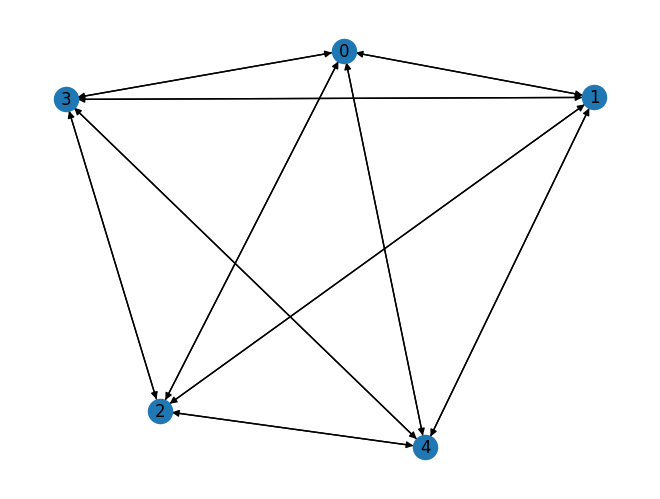

In [14]:
# set random seed for reproducibility
np.random.seed(seed=seed)

# number of nodes
n = 5

# since we want to solve basic VRP without taking into account capacities,
# we fix the maximum capacity C = n and customers' demands d = (1, ..., 1)
# this allows the vehicles to possibly visit all nodes,
# without restricting the routes

# maximum vehicle Capacity
C = n

# customers' demand
d = np.ones(n)
d[0] = 0

# heuristich bound of the number of vehicles needed to serve all customers
# To obtain the exact k_min we would need to solve a Bin Packing Problem
# Regardless, the heuristic bound usually works well too
kmin = int(np.ceil(np.sum(d)/C))

# number of vehicles
k = kmin + 1


# # Make both vehicles necessary
# C = int(np.ceil(np.sum(d)/2)+1)
# k = 2


# generate random Adjacency matrix
# first generate a random matrix where each entry is i.i.d. ~ Ber(p) with p = graph_density.
# Then assign the edges random weights i.i.d. ~ U({0,...,10})
graph_density = 3/3
E = np.multiply(np.random.binomial(1, p=graph_density, size=(n, n)),
                np.random.randint(1, 10, size=(n, n)))
# make it symmetrical (to avoid getting stuck in dead ends)
E = E + E.T
# take away the diagonal
E = E - np.diag(np.diag(E))

# generate graph from Adjacency matrix
G = nx.from_numpy_array(E, create_using=nx.DiGraph)

# fix depot node
depot = 0

# draw Graph using Fruchterman-Reingold force-directed algorithm
nx.draw(G, nx.spring_layout(G), with_labels=True)

In [15]:
E

array([[ 0, 16, 10, 10, 13],
       [16,  0,  9,  6,  3],
       [10,  9,  0,  8, 10],
       [10,  6,  8,  0, 10],
       [13,  3, 10, 10,  0]])

In [16]:
test_data['Num_Nodes'] = n
test_data['Num_Vehicles'] = k
test_data['Capacity'] = C
test_data['Customers_Demands'] = d
test_data['Graph_Sparsity'] = 1 - (np.sum(E>0)/(n*(n-1)))
test_data['Average_Degree'] = np.mean([np.mean(E[i, :]) for i in range(n)])
test_data['Fully_Connected'] = nx.is_strongly_connected(G)

# Useful functions

## D-Wave Embedding Info

In [17]:
# Function to take a look at the Minor-Embedding provided by DWave heuristic

def DWave_embedding_info(Q, hardware_graph):

  # create networkx graph for QUBO variables' dependencies
  G_qubo = nx.from_edgelist(Q)
  # create networkx object for annealer hardware graph
  G_hardware = nx.from_edgelist(hardware_graph)
  # heuristically compute the minor-embedding of G_qubo into G_hardware
  embedding = minorminer.find_embedding(G_qubo, G_hardware)

  # number of variables in QUBO formulation
  print('number of problem variables ', len(G_qubo.nodes))
  # total number of qubits available on hardware graph
  print('number of qubits in the hardware graph ', len(G_hardware.nodes))

  # print the embedding info

  # hardware qubits needed to embed the QUBO
  hw_qubits_counts = np.unique([qubit for hw_qubits in list(embedding.values()) for qubit in hw_qubits], return_counts=True)
  hw_qubits = hw_qubits_counts[0]
  print('number of HardWare qubits used: ', len(hw_qubits))

  # minimum and maximum number of physical qubits per logical variable
  lis = [(node, len(embedding[node])) for node in list(embedding.keys())]
  print('node with shortest chain and respective lenght: ', sorted(lis, key=lambda x: x[1])[0])
  print('node with longest chain and respective lenght: ', sorted(lis, key=lambda x: x[1], reverse=True)[0])

  # minimum and maximum number of logical variables per physical qubit
  print('qubit associated to lowest number of variables and related number of variables: ',
        hw_qubits[np.argmin(hw_qubits_counts[1])], np.min(hw_qubits_counts[1]))
  print('qubit associated to highest number of variables and related number of variables: ',
        hw_qubits[np.argmax(hw_qubits_counts[1])], np.max(hw_qubits_counts[1]))

  # return (num_QUBO_variables, num_HW_qubits_used, len_shortest_chain, len_longest_chain)
  return (len(G_qubo.nodes), len(hw_qubits), sorted(lis, key=lambda x: x[1])[0][1], sorted(lis, key=lambda x: x[1], reverse=True)[0][1])

## Build route from (node, timestep) tuples

In [18]:
def build_route_node_time(route, cluster):

  # sort the tuples (node, timestep) wrt timestep
  route.sort(key=lambda x: x[1])

  print(route)

  # check if route is a valid routing
  # each node in the cluster must be visited exactly once
  for node in cluster:
    cont = sum([1 for tpl in route if tpl[0]==node])
    if cont!=1:
      print('Not a valid routing: node visited more than once')
      return (route, False)

  # only one node must be visited per timestep
  for timestep in range(len(cluster)):
    cont = sum([1 for tpl in route if tpl[1]==timestep])
    if cont!=1:
      print('Not a valid routing: more than one node per timestep')
      return (route, False)

  route = [tpl[0] for tpl in route]
  return (route, True)

## Custom Louvain for clustering phase

In [19]:
# we want to cluster nodes based on distances, specifically
# we want nodes in the same cluster to have a small overall distance
# in order to reduce TSP objective. To do this, we define a new Graph
# where weights are exp(-weight) of the original weights (which are indeed distances).
# We do this because in Modularity Maximization A[i,j] is interpreted as
# similarity value between nodes (i,j). In this sense, nodes with higher similarity
# will tend to be clustered together. In our case however A[i,j] is the distance
# between nodes (i,j), but we dont want to cluster together far distanced node.
# On the contrary, we want nodes in the same cluster to be at small distances from
# one another. That's why we define E_inv and the new 'inverted' graph G_inv

E_inv = np.zeros(E.shape)
for i in range(E_inv.shape[0]):
  for j in range(E_inv.shape[1]):
    if E[i,j]!=0:
      E_inv[i,j] = np.exp(-E[i,j])

# generate graph from Adjacency matrix
G_inv = nx.from_numpy_array(E_inv, create_using=nx.DiGraph)

In [20]:
# greedy community detection
# A modified version of Louvain greedy algorithm where we now include also
# capacity constraints in community generation.
# Namely, a community cannot have nodes such that communty total demand exceed the
# community capacity
def greedy_community_detection(G, k, C, demands):

  E_condensed = E_inv
  num_nodes = n

  communities = {}
  for i in range(num_nodes):
    communities[i] = i

  # build partition
  partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
  # compute modularity
  modularity = nx.community.modularity(G, partition, weight='weight', resolution=1)
  initial_mod = modularity
  # keep repeting the process as long as the modularity
  modularity_increased = True

  # print(initial_mod)

  while modularity_increased==True:

    modularity = initial_mod

    # randomly shuffle the nodes
    permuted_nodes = np.random.permutation(num_nodes)

    for node in permuted_nodes:
      # print('\t', node)
      best_neighbor = node
      # compute neighboring nodes
      neighbors = [neigh for neigh in range(num_nodes) if E_condensed[node, neigh]>0]
      # we add the node itself as neighbor so that the community
      # is preserved if it is not convenient to merge the node with any
      # of its neighbors
      neighbors.append(node)
      # for each neighbor, try to merge the node with the neighbor
      # keep only the merging attaining maximum modularity
      for neigh in neighbors:
        comms = copy.deepcopy(communities) # used to temporaly merge communities
        nodes = [key for key in list(communities.keys()) if communities[key]==communities[node]]
        for v in nodes:
          comms[v] = comms[neigh]

        community_capacity = sum([d[i] for i in range(n) if comms[i]==comms[neigh]])

        # build partition
        new_partition = [[vertex for vertex in range(n) if comms[vertex]==comm_id] for comm_id in set(list(comms.values()))]
        # compute modularity
        new_modularity = nx.community.modularity(G, new_partition, weight='weight', resolution=1)
        # keep only the merging attaining maximum modularity
        if new_modularity > modularity and community_capacity<=C:
          best_neighbor = neigh
          modularity = new_modularity

      #   print(node, neigh, modularity, new_partition, new_modularity, '\n')

      # print(node, best_neighbor, modularity)

      nodes = [key for key in list(communities.keys()) if communities[key]==communities[node]]
      for v in nodes:
        communities[v] = communities[best_neighbor]

      partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
      new_modularity = nx.community.modularity(G, partition, weight='weight', resolution=1)
      # print(partition)
      # print(new_modularity)

    # print(communities)

    # update dictionary values
    values = list(set(list(communities.values())))
    for i in range(len(values)):
      keys = [key for key in list(communities.keys()) if communities[key]==values[i]]
      for key in keys:
        communities[key] = i

    # define the condensed graph and start again
    num_comms = len(set(list(communities.values())))
    num_nodes = num_comms
    E_condensed = np.zeros(shape = (num_comms, num_comms))
    for i in range(E_condensed.shape[0]):
      for j in range(E_condensed.shape[1]):
        E_condensed[i,j] = sum([E_inv[source, target] for source in range(n) for target in range(n)
                                if communities[source]==i and communities[target]==j])

    partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
    new_modularity = nx.community.modularity(G, partition, weight='weight', resolution=1)

    # print(partition)
    # print(initial_mod, new_modularity)

    if new_modularity>initial_mod:
      modularity_increased=True
      initial_mod = new_modularity
    else:
      modularity_increased=False

  # compute final communities
  partition = [[vertex for vertex in range(n) if communities[vertex]==comm_id] for comm_id in set(list(communities.values()))]
  communities = reduce_communities(G, partition, k)
  communities = check_depot_connection(G, communities)

  return communities

In [21]:
# if the number of communities exceeds k then we greedly move nodes so the
# reduce the number down to k. Important: we want the minimum possible
# decrease in modularity and also capacity constraints must not be violated.
# At each iteration we determine the most sparse community (which thus has lowest
# impact on overall modularity) and from such community we take the least connected node
# (which thus has lowest impact on the community modularity).
# We then insert such node in another community, where such community is chosen
# so that the insertion would have smallest impact on overall modularity.
# Beware: before inserting the node we must check it has connections in the new community
# and also that capacity constraints are not violated.

def reduce_communities(G, communities, k):
  while len(communities) > k:
    # print(len(communities), k)
    initial_modularity = nx.community.modularity(G, communities, weight='weight', resolution=1)
    # print('start', communities)
    communities = [community for community in communities if len(community)>0]
    # print('filtered', communities)
    community = find_least_connected_community(communities)
    # print('lcc', community)
    least_connected_node = find_least_connected_node(community)
    # print('lcn', least_connected_node)
    i = communities.index(community)
    # print('index', i)
    modularity_decrease = float('inf')
    for j, other_community in enumerate(communities):
      if i!=j and len([node for node in other_community if E_inv[node, least_connected_node]!=0])>0:
        new_communities = copy.deepcopy(communities)
        new_communities[i].remove(least_connected_node)
        new_communities[j].append(least_connected_node)
        modularity = nx.community.modularity(G, new_communities, weight='weight', resolution=1)
        community_capacity = sum([d[node] for node in new_communities[j]])
        if initial_modularity - modularity < modularity_decrease and community_capacity<=C:
          target_comm = j
          modularity_decrease = initial_modularity - modularity
    # print(target_comm)
    communities[i].remove(least_connected_node)
    communities[target_comm].append(least_connected_node)

  return communities



def find_least_connected_node(community):
  least_connected_node = None
  min_degree = float('inf')
  for node in community:
    degree = sum([E_inv[node, neigh] for neigh in community])
    if degree < min_degree:
      least_connected_node = node
      min_degree = degree
  return least_connected_node

def find_least_connected_community(communities):
  min = float('inf')
  for community in communities:
    density = sum([E_inv[i,j] for i in community for j in community])
    if density < min:
      least_connected_community = community
      min = density
  return least_connected_community

In [22]:
# all the communities must have at leat a node connected to the depot
# if that is not the case we manually move nodes so to connect each community
# to the depot while also providing smallest loss in modularity and
# capacity constraint satisfaction

# from each community not connected to the depot we take the lowest connected node in the community,
# we then want to swap such node with a depot-connected node of an other community.
# Beware: in swapping the nodes we must check that the nodes have connections in their new
# communities, otherwise isolated point would emerge. Moreover, che capacity constraints
# on both communities must still be satisfied after the swapping is complete.
# To choose the depot connected community on which to perform the swap we use a greedy approach,
# testing all the communities and choosing the one whose swap would result in
# minimum modularity deterioration

def check_depot_connection(G, communities):

  # for each community count the number of connection to the depot
  count_connection_to_depot = [sum([1 for node in community if E_inv[0, node]!=0]) for community in communities]

  # if every community has at least a node connected to the depot then we are good
  if 0 not in count_connection_to_depot:
    return communities

  # compute initial modularity
  initial_modularity = nx.community.modularity(G, communities, weight='weight', resolution=1)

  # repeat as long as there are communities not connected to the depot
  while 0 in count_connection_to_depot:

    # get community with no connections to the depot
    i = count_connection_to_depot.index(0)    # index of the depot not-connected community

    # from depot not-connected community we want to take the node which has the
    # lowest connectivity with other nodes in the community
    lowest_connectivity = []
    for node in communities[i]:
      degree = sum([E_inv[node, j] for j in communities[i]])
      lowest_connectivity.append((node, degree))
    lowest_connectivity.sort(key=lambda x: x[1])

    # we implement greedy swaps based on mimimum modularity deterioration
    modularity_decrease = float('inf')

    # Beware: we cannot swap nodes with communities which have only
    # one connection to the depot, as it that case after swapping the community
    # would remain without connection to the depot
    for j, other_community in enumerate(communities):
      if i!=j and count_connection_to_depot[j]>=2:
        # we want to take the depot-connected node which has the lowest connectivity with other nodes in the community
        depot_connectivity = []
        for node in other_community:
          if E_inv[node, 0]+E_inv[0, node]>0:
            degree = sum([E_inv[node, j] for j in other_community])
            depot_connectivity.append((node, degree))
        depot_connectivity.sort(key=lambda x: x[1])  # sorts in place

        for node_1 in [lcn[0] for lcn in lowest_connectivity]:    # lcn = least connected node
          for node_2 in [dlcn[0] for dlcn in depot_connectivity]:   # dlcn = depot least connected node

            # check wether the nodes have connections in case of swap
            if len([vertex for vertex in other_community if E_inv[node_1, vertex]!=0])>0 and len([vertex for vertex in communities[i] if E_inv[node_2, vertex]!=0])>0:

              new_communities = copy.deepcopy(communities)

              # substitute node_1 in original community
              # with node_2, which is depot connected
              new_communities[i].remove(node_1)
              new_communities[i].append(node_2)

              # substitute node_2 in depot connected community
              # with node_1 from depot not-connected community
              new_communities[j].remove(node_2)
              new_communities[j].append(node_1)

              # compute new modularity
              modularity = nx.community.modularity(G, new_communities, weight='weight', resolution=1)

              # compute capacity of the new communities
              community_capacity_i = sum([d[node] for node in new_communities[i]])
              community_capacity_j = sum([d[node] for node in new_communities[j]])

              if initial_modularity - modularity < modularity_decrease and community_capacity_i <=C and community_capacity_j <=C:   # capacity constraint
                source_node = node_1
                target_node = node_2
                target_comm = j
                modularity_decrease = initial_modularity - modularity
                break
            break

    # print(target_comm)
    communities[i].remove(source_node)
    communities[i].append(target_node)
    communities[target_comm].remove(target_node)
    communities[target_comm].append(source_node)

    # for each community count the number of connection to the depot
    count_connection_to_depot = [sum([1 for node in community if E_inv[0, node]!=0]) for community in communities]

  return communities

In [23]:
# all the communities must satisfy capacity constraints

# from each community exceeding the capacity constraint we take the lowest connected node in the community,
# we then want to move such node to an other community (satisfying CCs) while ensuring CCs are still satisfied.
# Beware: in moving the nodes we must check that the nodes have connections in their new
# communities, otherwise isolated point would emerge.
# To choose the community to which move the node we use a greedy approach,
# testing all the communities and choosing the one which would result in
# minimum modularity deterioration

def check_capacity_constraints(G, communities):

  # for each community check the capacity
  check_capacities = [sum([d[node] for node in community]) for community in communities]

  # if every community satisfies CCs then we are good
  if len([1 for c in check_capacities if c>C])==0:
    return communities

  # compute initial modularity
  initial_modularity = nx.community.modularity(G, communities, weight='weight', resolution=1)

  # repeat as long as there are communities not satisfying the CC
  while len([1 for c in check_capacities if c>C])>0:

    # get community not satisfying CCs
    for j in range(len(communities)):
      if sum([d[node] for node in communities[j]])>C:
        i = j   # index of the community not adhering to CCs

    # from such community we want to take the node which has the
    # lowest connectivity with other nodes in the community
    lowest_connectivity = []
    for node in communities[i]:
      degree = sum([E_inv[node, j] for j in communities[i]])
      lowest_connectivity.append((node, degree))
    lowest_connectivity.sort(key=lambda x: x[1])

    # we implement greedy moves based on mimimum modularity deterioration
    modularity_decrease = float('inf')

    for j, other_community in enumerate(communities):
      if i!=j and check_capacities[j]<C:

        for node_1 in [lcn[0] for lcn in lowest_connectivity]:    # lcn = least connected node in the community exceeding CCs

          # check wether the node would have connections in case of move
          if len([vertex for vertex in other_community if E_inv[node_1, vertex]!=0])>0 and check_capacities[j]+d[node_1]<=C:

            new_communities = copy.deepcopy(communities)

            # move node_1 to j-th community
            new_communities[i].remove(node_1)
            new_communities[j].append(node_1)

            # compute new modularity
            modularity = nx.community.modularity(G, new_communities, weight='weight', resolution=1)

            # compute capacity of the new target community
            community_capacity_j = sum([d[node] for node in new_communities[j]])

            if initial_modularity - modularity < modularity_decrease and community_capacity_j <= C:   # capacity constraint
              source_node = node_1
              target_comm = j
              modularity_decrease = initial_modularity - modularity
              break

    # print(target_comm)
    communities[i].remove(source_node)
    communities[target_comm].append(source_node)

    # for each community check the CCs
    check_capacities = [sum([d[node] for node in community]) for community in communities]

  return communities

In [24]:
start_time = now()
louvain_clusters = greedy_community_detection(G_inv, k, C, d)
end_time = now()

test_data['Louvain_Execution_Time'] = end_time-start_time

print(louvain_clusters)
nx.community.modularity(G_inv, louvain_clusters, weight='weight', resolution=1)

[[1, 4], [0, 2, 3]]


0.01386487042390577

In [25]:
for cluster in louvain_clusters:
  if 0 not in cluster:
    cluster.append(0)
louvain_clusters

[[1, 4, 0], [0, 2, 3]]

In [26]:
# # check if depot_connection works fine (In this runtime nodes 1, 2, 8, are not connected to the depot (25 nodes in total))
# comms = [[1, 2, 8], [0, 6, 7, 4, 10, 14, 15, 19, 22, 23, 21], [3, 5, 9, 12, 17, 18, 20, 24, 11, 16, 13]]
# print(nx.community.modularity(G_inv, comms, weight='weight', resolution=1))
# comms = check_depot_connection(comms)
# print(comms)
# print(nx.community.modularity(G_inv, comms, weight='weight', resolution=1))

In [27]:
louvain = nx.community.louvain_communities(G_inv, weight='weight', resolution=1)
print(louvain)
nx.community.modularity(G_inv, louvain, weight='weight', resolution=1)

[{0, 2, 3}, {1, 4}]


0.01386487042390577

## Plot VQA solutions distribution

In [28]:
def plot_solutions_distribution_VQA(qp, result, cluster=list(range(n)), problem='routing'):

  hist = {}

  if problem=='routing':
    for s in result.samples:
      x = ''
      for i in cluster:
        for j in cluster:
          if i!=j and E[i,j]!=0:
            x += str(int(s.x[qp.variables_index[f'x[{i},{j}]']]))

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='routing2':
    for s in result.samples:
      x = ''
      for i in cluster:
        for t in range(len(cluster)):
          x += str(int(s.x[qp.variables_index[f'x[{i},{t}]']]))

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='clustering':
    for s in result.samples:
      x = ''
      for v in range(k):
        for i in range(n):
          x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  # Create a matplotlib figure and axes
  fig, ax = plt.subplots()

  plot_distribution(hist, sort='hamming', target_string='0'*len(x), ax=ax)

  # Adjust x-axis label scaling and rotation
  ax.tick_params(axis='x', labelrotation=90, labelsize=5)  # Rotate the x-labels by 90 degrees
  ax.set_xticks(np.arange(len(hist)))  # Set the x-ticks at the positions of the bars
  ax.set_xticklabels(hist.keys())  # Set the x-labels using the keys of the data dictionary

  plt.show()

## Plot QUBO solutions distribution

In [29]:
# plot solutions distribution among feasible QUBO solutions
def plot_solutions_distribution(samples, cluster=list(range(n)), problem='routing'):

  hist = {}

  if problem=='routing':
    for s in samples:
      x = ''
      for i in cluster:
        for j in cluster:
          if i!=j and E[i,j]!=0:
            x += str(s.sample[f'x[{i},{j}]'])

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='routing2':
    for s in samples:
      x = ''
      for i in cluster:
        for t in range(len(cluster)):
          x += str(s.sample[f'x[{i},{t}]'])

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  elif problem=='clustering':
    for s in samples:
      x = ''
      for v in range(k):
        for i in range(n):
          x += str(s.sample[f'z[{v},{i}]'])

      if x not in list(hist.keys()):
        hist[x] = 1
      else:
        hist[x] += 1

  # Create a matplotlib figure and axes
  fig, ax = plt.subplots()

  plot_distribution(hist, sort='hamming', target_string='0'*len(x), ax=ax)

  # Adjust x-axis label scaling and rotation
  ax.tick_params(axis='x', labelrotation=90, labelsize=5)  # Rotate the x-labels by 90 degrees
  ax.set_xticks(np.arange(len(hist)))  # Set the x-ticks at the positions of the bars
  ax.set_xticklabels(hist.keys())  # Set the x-labels using the keys of the data dictionary

  plt.show()

## QUBO to Qiskit Quadratic Program

In [30]:
def QUBO_to_QuadProg(Q, offset):

  # construct the Quadratic Program using pyqubo dictionaries
  qp = QuadraticProgram()

  # dictionary of linear terms
  linear = {}
  # dictionary of quadratic interactions
  quadratic = {}

  for key in Q.keys():
    if key[0]==key[1]:
      # Add variables
      qp.binary_var(name=key[0])
      linear[key[0]] = Q[key]   # add linear term to the Quadratic Program
    else:
      quadratic[key] = Q[key]   # add quadratic term to the Quadratic Program

  # Add objective
  qp.minimize(constant=offset, linear=linear, quadratic=quadratic)
  # print(qp.prettyprint())

  # # Ising Hamiltonian associated to the Quadratic Program
  # ising_operator = qp.to_ising()

  return qp

## TSP DFJ GAMA

In [31]:
def TSP_DFJ_gama(cluster, clusters_str):

################################################################################

  # useful function for Graver Augmentation

  # Objective function definition
  def f(x):
    return np.sum([obj_coeffs[i]*x[i] for i in range(len(obj_coeffs))])

  # Constraints satisfaction
  def const(x):
      return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

################################################################################

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP_GAMA')
  # m.Params.LogToConsole = 0

  # edge variables
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

  # dictionary of slack variables for subtour elimination constraint
  s = {}

  # update model
  m.update()

  # only one vehicle on edge (i, j) for every (i, j)
  m.addConstrs((sum(x[(i, j)] for i in cluster if E[i, j]!=0 and i!=j) == 1 for j in cluster), name='enter_node')
  m.addConstrs((sum(x[(i, j)] for j in cluster if E[i, j]!=0 and i!=j) == 1 for i in cluster), name='leave_node')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,j)]
                for i in cluster
                for j in cluster if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # count number of found subtours
  cont = 0

  while bool_subtour == True:

    if len(subtour)>0:

        # define slack variable for subtour elimination
      num_var_enc = int(np.ceil(np.log2(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j])+1)))
      for t in range(num_var_enc):
        s[(cont,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{cont},{t}]")

      m.update()

      # add subtour elimination constraint
      m.addConstr( -sum(x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j) +
                    (-1 + sum([2**t * s[(cont,t)] for t in range(num_var_enc-1)]) +
                    (sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) -
                    sum([2**t for t in range(num_var_enc-1)]))*s[(cont, num_var_enc-1)])   # s[cont]
                    == -1.0, name=f'subtour_elimination({cont})')

    # update model
    m.update()

    # Save model for inspection
    m.write('TSP_GAMA.lp')

    # Run optimization engine
    A = m.getA()
    A = A.toarray()
    b = np.array(m.getAttr("RHS", m.getConstrs()), int)
    obj_coeffs = m.getAttr("Obj", m.getVars())

    # compute graver basis elements
    graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
    # print(len(graver_elems), ' graver elements found.')

    # compute feasible solutions
    feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
    # print(len(feas_sols), ' feasible solutions found.')

    # Multiseed Augmentation
    final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

    # get best solution
    x_opt = final_sols[np.argmin(final_obj_full), :]

    # get route
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j:
          route.append((i,j))

    route = [route[i] for i in range(len(route)) if x_opt[i]>1e-6]

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  test_data_gama['QuGAMA_Num_Graver_Basis_TSP'].append(len(graver_elems))
  test_data_gama['QuGAMA_Num_Feasible_Sols_TSP'].append(len(feas_sols))

  # compute final objective function value
  obj = f(x_opt)
  return (route, obj)

## TSP DFJ QUBO

In [32]:
def TSP_DFJ_qubo_VQA(cluster, p = np.sum(E)+1, cl_opt_index=11, num_iter=200, VQA='Numpy', circuit_depth=1, show_hist=False, clusters_str=''):

  cluster = set(cluster)
  n = len(cluster)
  M = 1e6

  # create QUBO variables for the edges
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = Binary(f'x[{i},{j}]')

  # ditionary of slack variables for subtour elimination constraints
  s = {}

  # count number of subtours
  cont = 0

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # build QUBO by manually adding objective and constraints

  # define objective function
  obj = sum(E[i,j]*x[(i,j)] for i in cluster for j in cluster if E[i,j]!=0 and i!=j)

  # add the objective
  Q =  obj

  # add the constraints
  # only one edge coming out from each node
  Q += p*sum([Constraint((sum([x[(i, j)] for j in cluster if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in cluster])

  # only one edge entering each node
  Q += p*sum([Constraint((sum([x[(i, j)] for i in cluster if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in cluster])

  classic_optimizer = classic_optimizers[cl_opt_index](maxiter=num_iter)

  while bool_subtour == True:

    if len(subtour)>0:
      # print(subtour)
      s[cont] = LogEncInteger(f's[{cont}]', (-1, -1 + int(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]))))
      Q += p*M*(Constraint((-sum([x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) + s[cont] + 1)**2,
                        label=f'subtour_elimination_{cont}'))
    # get QUBO matrix
    model = Q.compile()
    Q_dict, offset = model.to_qubo()

    # Convert QUBO to Qiskit Quadratic Program
    qp = QUBO_to_QuadProg(Q_dict, offset)

    # print(qp.prettyprint())

    # Solve via Variational Quantum Algorithms
    # # Choose the classical optimizer
    # classic_optimizer = SPSA(maxiter=maxiter)

    # Lists used by callback to store optimization progress
    counts_callback = []
    values_callback = []

    # Choose Variational Quantum Algorithm
    if VQA=='Numpy':
      vqa = NumPyMinimumEigensolver()
    elif VQA=='VQE':
      ansatz = RealAmplitudes(reps=circuit_depth)  # VQE ansatz
      vqa = SamplingVQE(qiskit_sampler, ansatz=ansatz, optimizer=classic_optimizer, callback=store_intermediate_result)
    elif VQA=='QAOA':
      vqa = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result)

    # Run VQA optimization
    optimizer = MinimumEigenOptimizer(vqa)
    result = optimizer.solve(qp)

    # get best_sample's edges
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j and result.x[qp.variables_index[f'x[{i},{j}]']] > 1e-6:
          route.append((i, j))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*result.x[qp.variables_index[f'x[{i},{j}]']]
                  for i in cluster for j in cluster if E[i,j]!=0 and i!=j])

  if show_hist==True:
    plot_solutions_distribution_VQA(qp, result, cluster, problem='routing')

  return (route, obj)

In [33]:
def TSP_DFJ_qubo(cluster, p = np.sum(E)+1, show_hist=False, clusters_str=''):

  cluster = set(cluster)
  n = len(cluster)

  # create QUBO variables for the edges
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = Binary(f'x[{i},{j}]')

  # ditionary of slack variables for subtour elimination constraints
  s = {}

  # count number of subtours
  cont = 0

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # build QUBO by manually adding objective and constraints

  # define objective function
  obj = sum(E[i,j]*x[(i,j)] for i in cluster for j in cluster if E[i,j]!=0 and i!=j)

  # add the objective
  Q =  obj

  # add the constraints
  # only one edge coming out from each node
  Q += p*sum([Constraint((sum([x[(i, j)] for j in cluster if j!=i and E[i, j]!=0])-1)**2, label=f'leave_node_{i}') for i in cluster])

  # only one edge entering each node
  Q += p*sum([Constraint((sum([x[(i, j)] for i in cluster if i!=j and E[i, j]!=0])-1)**2, label=f'enter_node_{j}') for j in cluster])

  while bool_subtour == True:

    if len(subtour)>0:
        s[cont] = LogEncInteger(f's[{cont}]', (-1, -1 + int(sum([1 for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]))))
        Q += p*(Constraint((-sum([x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j]) + s[cont] + 1)**2,
                          label=f'subtour_elimination_{cont}'))
    # get QUBO matrix
    model = Q.compile()
    Q_dict, offset = model.to_qubo()



    # solve the model with the chosen sampler
    if solver=='SimulAnneal':   # classic solver
      sampleset = sampler.sample_qubo(Q_dict, num_reads=300, num_steps=1000)
    elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
      sampleset = sampler.sample_qubo(Q_dict)
    elif solver=='Advantage_system6.2':   # quantum solver
      sampleset = sampler.sample_qubo(Q_dict, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])
      test_data['QA_QPU_Access_Time_TSP'+clusters_str] += sampleset.info['timing']['qpu_access_time']

    # get obtained solutions
    samples = model.decode_sampleset(sampleset)

    if show_hist==True:
      plot_solutions_distribution(samples, cluster, problem='routing')

    # take only valid solutions (actual routes)
    samples = [s for s in samples if is_feasible(s.sample, s.energy, cluster)==True]

    # take only best solution (feasible and with minimum energy)
    best_sample = min(samples, key=lambda s: s.energy)

    # get best_sample's edges
    route = []
    for i in cluster:
      for j in cluster:
        if E[i,j]!=0 and i!=j and best_sample.sample[f'x[{i},{j}]'] > 1e-6:
          route.append((i, j))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*best_sample.sample[f'x[{i},{j}]']
                  for i in cluster for j in cluster if E[i,j]!=0 and i!=j])

  # save info in dataframe
  # save num_variables in dataframe
  G_qubo = nx.from_edgelist(Q_dict)
  test_data['Max_Num_Qubits_TSP'+clusters_str].append(len(G_qubo.nodes))

  # First of all let's take a look at the Minor-Embedding
  if solver=='Advantage_system6.2':
    emb_info = DWave_embedding_info(Q_dict, hardware_graph[1])
    # save in dataframe
    test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str].append(emb_info[1])
    test_data['Shortest_Chain_Length_TSP'+clusters_str].append(emb_info[2])
    test_data['Longest_Chain_Length_TSP'+clusters_str].append(emb_info[3])

  return (route, obj)

In [34]:
def is_feasible(sample, energy, cluster):

  # original objective function value
  obj = np.sum([E[i,j]*sample[f'x[{i},{j}]']
                for i in cluster
                for j in cluster
                if E[i,j]!=0 and i!=j])

  return obj==energy

## TSP DFJ Gurobi

In [35]:
def TSP_DFJ_gurobi(cluster, clusters_str):

  cluster = set(cluster)
  n = len(cluster)

  # Declare and initialize model
  m = gp.Model('TSP')

  # edge variables
  x = {}
  for i in cluster:
    for j in cluster:
      if E[i,j]!=0 and i!=j:
        x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

  # dictionary of slack variables for subtour elimination constraint
  s = {}

  # update model
  m.update()

  # only one vehicle on edge (i, j) for every (i, j)
  m.addConstrs((sum(x[(i, j)] for i in cluster if E[i, j]!=0 and i!=j) == 1 for j in cluster), name='enter_node')
  m.addConstrs((sum(x[(i, j)] for j in cluster if E[i, j]!=0 and i!=j) == 1 for i in cluster), name='leave_node')

  # update model
  m.update()

  # Objective: minimize total cost of all assignments
  obj = np.sum([E[i,j]*x[(i,j)]
                for i in cluster
                for j in cluster if E[i,j]!=0 and i!=j])

  m.setObjective(obj, GRB.MINIMIZE)

  # update model
  m.update()

  # check whether current solution has subtours
  bool_subtour = True
  subtour = []

  # count number of found subtours
  cont = 0

  while bool_subtour == True:

    if len(subtour)>0:
      # add subtour elimination constraint
      m.addConstr(sum(x[(i, j)] for i in subtour for j in cluster.difference(subtour) if E[i, j]!=0 and i!=j) >= 1, name='subtour_elimination')

    # update model
    m.update()

    # Save model for inspection
    m.write('TSP_gurobi.lp')

    # Run optimization engine
    m.optimize()

    # get route
    route = []
    for v in m.getVars():
      if v.varName[0]=='x' and v.x > 1e-6:
        nodes_indices = re.findall(r'\d+', v.varName)
        route.append((int(nodes_indices[0]), int(nodes_indices[1])))

    bool_subtour = contains_subtours(cluster, route)[0]
    if bool_subtour==True:
      cont += 1
      subtour = set(contains_subtours(cluster, route)[1])

  # compute final objective function value
  obj = np.sum([E[i,j]*x[(i,j)].X
                  for i in cluster
                  for j in cluster if E[i,j]!=0 and i!=j])

  test_data['Gurobi_Execution_Time_TSP'+clusters_str] += m.runtime

  return (route, obj)

## check subtours

In [36]:
def contains_subtours(cluster, edges, VERBOSE=False):

  n = len(cluster)
  routes = []
  unvisited_nodes = list(cluster)

  while len(unvisited_nodes)>0:
    route = []
    initial_node = unvisited_nodes[0]
    route.append(initial_node)
    next_node = [edge[1] for edge in edges if edge[0]==initial_node]
    if len(next_node)!=1:
      print('Not a valid route')
      return
    next_node = next_node[0]
    route.append(next_node)
    while len(route)<n and next_node!=initial_node:
      next_node = [edge[1] for edge in edges if edge[0]==next_node]
      if len(next_node)!=1:
        print('Not a valid route')
        return
      next_node = next_node[0]
      route.append(next_node)
    routes.append(route)

    # update list on not yet visited nodes
    unvisited_nodes = [node for node in unvisited_nodes if route.count(node)==0]

  if len(routes)>1:
    subtour = [route for route in routes if 0 not in route][0]
    if VERBOSE==True:
      print('subtour: \t', subtour)
    return (True, subtour)

  return (False, routes)

## check if clustering is a valid clustering

In [37]:
def is_valid_clustering_MM(clusters):

  # at most k clusters
  if len(clusters)>k:
    return (False, clusters)

  # each cluster must satisfy capacity constraint
  Cs = [np.sum([d[node] for node in cluster]) for cluster in clusters]
  if len([el for el in Cs if el>C])>0:
    return (False, clusters)

  # each cluster must be connected to the depot
  depot_conns = [np.sum([E[0, i] + E[i,0] for i in cluster]) for cluster in clusters]
  if len([el for el in depot_conns if el<2])>0:
    return (False, clusters)

  # each node must be visited exactly once
  visited_nodes = [node for cluster in clusters for node in cluster]
  visited_nodes, num_visits = np.unique(visited_nodes, return_counts=True)

  if 0 not in set(visited_nodes) or num_visits[0]!=k:
    return (False, clusters)

  for i in range(1, n):
    if i not in set(visited_nodes) or num_visits[i]!=1:
      return (False, clusters)

  return (True, clusters)

In [38]:
def is_valid_clustering(clusters, VERBOSE=False):

  # store the clusters
  clustering = []

  # get used vehicles
  vehicles = set([elem[0] for elem in clusters])

  # for each vehicle get the visited customers
  for vehicle in vehicles:
    clustering.append([elem[1] for elem in clusters if elem[0]==vehicle])

  # to be a valid clustering each node must be visited by exactly one vehicle
  # i.e. each node must appear in exactly one cluster
  cont = {}
  for i in range(1, n):
    cont[i] = sum([c.count(i) for c in clustering])
    if cont[i]!=1:
      if VERBOSE==True:
        print('Not a valid clustering: node served by multiple vehicles')
        print(clustering)
      return (False, clustering)

  # Also, the depot must be in each cluster
  cont[0] = sum([c.count(0) for c in clustering])
  if cont[0]!=len(clustering):
    if VERBOSE==True:
      print('Not a valid clustering: depot not in every cluster')
      print(clustering)
    return (False, clustering)

  # Moreover, the capacity of each vehicle must not be exceeded
  for c in clustering:
    if sum([d[node] for node in c])>C:
      if VERBOSE==True:
        print('Not a valid clustering: capacity exceeded')
        print(clustering)
      return (False, clustering)

  if VERBOSE==True:
    print('Valid clustering')
    print(clustering)

  return (True, clustering)

## get clusters from annealing sample

In [39]:
def get_clusters_from_sample(sample):
  clusters = []
  for v in range(k):
    for i in range(n):
      if sample[f'z[{v},{i}]']==1:
        clusters.append((v, i))
  return clusters

## check if feasible solution is an actual route

In [40]:
def is_valid_routing(edges, VERBOSE=False, formulation=1):

  # here we save the final routes (if any)
  routes = []

  # get starting edges of each route
  if formulation==1:
    for edge in edges:    # edge = (node i, node j)
      if edge[0]==0:
        routes.append([edge[0], edge[1]])

    # attempt to build the routes
    for i in range(len(routes)):
      # build route for i-th vehicle
      next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
      if next_nodes == []:
        pass
      elif len(next_nodes)>1:   # if we have multiple next_nodes, that means there are multiple edges coming out from the same customer. Infeasible
        if VERBOSE==True:
          print('Not a valid routing')
        return (False, routes)
      else:
        next_node = next_nodes[0]
        routes[i].append(next_node)
        while (len(routes[i])<n) and (next_node!=0) and (next_nodes!=[]):
          next_nodes = [edge[1] for edge in edges if edge[0]==routes[i][-1]]
          if len(next_nodes)>1:   # if we have multiple next_nodes, that means there are multiple edges coming out from the same customer. Infeasible
            if VERBOSE==True:
              print('Not a valid routing')
            return (False, routes)
          elif len(next_nodes) == 1:
            next_node = next_nodes[0]
            routes[i].append(next_node)

  # for each route, check wheter the first and last nodes are zero (depot)
  for route in routes:
    first_node = route[0]
    last_node = route[-1]
    if first_node!=0 or last_node!=0:
      if VERBOSE==True:
        print('Not a valid routing')
      return (False, routes)

  # count the number of times each node appears among the routes
  cont = {}
  for i in range(n):
    cont[i] = sum([route.count(i) for route in routes])

  # the depot must be visited 2*k times
  # k edges leaving the depot
  # k edges returning to the depot
  if cont[0]!=2*k:
    if VERBOSE==True:
        print('Not a valid routing')
    return (False, routes)

  # check wether each other node is visited exactly once
  for i in range(1, n):
    if cont[i]!=1:
      if VERBOSE==True:
        print('Not a valid routing')
      return (False, routes)

  if VERBOSE==True:
    print('Valid routing. The routes are\n')
    for route in routes:
      print(route)

  return (True, routes)

## get visited edges from annealing sampling

In [41]:
# get edges
def get_edges_from_sample(sample):

  edges = []

  for i in range(n):
    for j in range(n):
      if i!=j and E[i,j]!=0 and sample[f'x[{i},{j}]']==1:
        edges.append((i, j))

  return edges

## Graver Augmentation

In [42]:
# Define rules to choose augmentation element, either the best one (argmin) or the first one that is found
def argmin(iterable):
  return min(enumerate(iterable), key=lambda x: x[1])

def greedy(iterable):
  for i, val in enumerate(iterable):  #[i = graver element, val=(obj, step_size)]
      if val[1] != 0:
          return i, val
  return i, val

In [43]:
# We can just have a single step move (works well with greedy approach)
def single_move(g, fun, x, x_lo = None, x_up = None):
  if x_lo is None:
      x_lo = np.zeros_like(x)
  if x_up is None:
      x_up = np.ones_like(x)

  alpha = 0

  if (x + g <= x_up).all() and (x + g >= x_lo).all():
      if fun(x + g) < fun(x):
          alpha = 1
  elif (x - g <= x_up).all() and (x - g >= x_lo).all():
      if fun(x - g) < fun(x) and fun(x - g) < fun(x + g):
          alpha = -1

  return (fun(x + alpha*g), alpha)

In [44]:
def augmentation(grav, func, x, x_lo = np.zeros(n*n), x_up = np.ones(n*n), VERBOSE = True, itermax = 1000):
  # Let's perform the augmentation and return the number of steps and the best solution
  # OPTION = 3 # Greedy augmentation, select using first found
  dist = 1
  gprev = None
  k = 1
  if VERBOSE:
      print("Initial point:", x)
      print("Objective function:",func(x))
  while dist != 0 and k < itermax:
    g1, (obj, dist) = greedy(single_move(g=e, fun=func, x=x, x_lo=x_lo, x_up=x_up) for e in grav)
    x = x + grav[g1]*dist
    gprev = grav[g1]
    if VERBOSE:
        print("Iteration ", k)
        print('Graver element, (obj, alpha):', g1, (obj, dist))
        print("Augmentation direction:", gprev)
        print("Objective function:", func(x))
        print("Current point:", x)
        print("Are constraints satisfied?", const(x))
    else:
        if k%50 == 0:
            print(k)
            print(obj)
    k += 1
  return(k, obj, x)

In [45]:
def get_feasible(A, b, sampler, samples=500, refine_almost_feasible=False):

  AA = np.dot(A.T, A)
  h = -2.0*np.dot(b.T, A)
  Q = AA + np.diag(h)
  offset = np.dot(b.T, b) + 0.0

  # Define Binary Quadratic Model
  bqm = dimod.BinaryQuadraticModel(Q, "BINARY", offset=offset)

  # solve the model with the chosen sampler
  if solver=='SimulAnneal':   # classic solver
    response = sampler.sample(bqm, num_reads=samples, num_steps=1000)
  elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
    response = sampler.sample(bqm)
  elif solver=='Advantage_system6.2':   # quantum solver
    response = sampler.sample(bqm, num_reads=samples, annealing_time=qpu.properties["annealing_time_range"][1])

  # remove duplicates from the sample set
  response = response.aggregate()

  filter_idx = [i for i, e in enumerate(response.record.energy) if e == 0.0] # get only actual feasible solutions
  feas_sols = response.record.sample[filter_idx]

  # feas_sols contains the actual solutions of the QUBO problem,
  # namely those x such that Ax=0 (to get graver elems) and Ax=b (to get feasible solutions)
  # Usually, when solving for the graver elements it might happen that we also find several
  # low energy solutions y such that Ay ~ 0 but Ay!=0.
  # Instead of discarding such y's, it is convenient to combine them in order
  # to create new graver elements. That's what we do in the next lines of code

  if refine_almost_feasible==True:

    # get unfeasible solutions
    filter_idx = [i for i, e in enumerate(response.record.energy) if e != 0.0]
    sols = response.record.sample[filter_idx]
    # compute error matrix
    Error_matrix = np.dot(A, sols.T)

    # almost feasible solutions with gap-value of 1
    err_one_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==1]
    almost_feas_sols_1 = sols[err_one_sols]
    # create new feasible solutions
    feas_sols_1 = filter_sol_abs_error(A, almost_feas_sols_1, abs_error=1)
    # stack everything togheter
    if feas_sols_1.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_1])

    # almost feasible solutions with gap-value of 2
    err_two_sols = [i for i in range(Error_matrix.shape[1]) if np.sum(np.abs(Error_matrix[:, i]))==2]
    almost_feas_sols_2 = sols[err_two_sols]
    # create new feasible solutions
    feas_sols_2 = filter_sol_abs_error(A, almost_feas_sols_2, abs_error=2)
    # stack everything togheter
    if feas_sols_2.shape[0]>0:
      feas_sols = np.vstack([feas_sols, feas_sols_2])

  # remove duplicate solutions
  feas_sols = np.unique(feas_sols, axis=0)
  return feas_sols

In [46]:
# this functions takes as input a set of almost feasible solutions
# and combines them to create new actual feasible solutions
def filter_sol_abs_error(A, sols, abs_error=1):

  plus_one_group = []
  minus_one_group = []
  for i in range(sols.shape[0]):
    if np.sum(np.dot(A, sols[i].T))==abs_error:
      plus_one_group.append(sols[i])
    elif np.sum(np.dot(A, sols[i].T))==-abs_error:
      minus_one_group.append(sols[i])

  plus_one_group = np.array(plus_one_group)
  minus_one_group = np.array(minus_one_group)

  new_sols = []

  for i in range(plus_one_group.shape[0]):
    for j in range(i, plus_one_group.shape[0]):
      curr_sol = plus_one_group[i] - plus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(minus_one_group.shape[0]):
    for j in range(i, minus_one_group.shape[0]):
      curr_sol = minus_one_group[i] - minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)
        new_sols.append(-curr_sol)

  for i in range(plus_one_group.shape[0]):
    for j in range(minus_one_group.shape[0]):
      curr_sol = plus_one_group[i] + minus_one_group[j]
      if np.sum(np.abs(np.dot(A, curr_sol.T)))==0:
        new_sols.append(curr_sol)

  new_sols = np.array(new_sols)
  return new_sols

In [47]:
def graver_multiseed_augmentation(feas_sols, graver_elems, const, f):

  if len(feas_sols)==0:
    print('No feasible solutions to augment')
    return

  init_obj = np.zeros((len(feas_sols)))
  iters_full = np.zeros((len(feas_sols)))
  final_obj_full = np.zeros((len(feas_sols)))
  times_full = np.zeros((len(feas_sols)))
  final_sols = np.zeros(shape=(len(feas_sols), feas_sols[0].shape[0]))

  for i, sol in enumerate(feas_sols):
    if not const(sol):
      print("Infeasible")
      pass
    init_obj[i] = f(sol)
    start = time.process_time()
    iter, f_obj, xf = augmentation(grav = graver_elems, func = f, x = sol,
                                   x_lo = np.zeros(feas_sols[0].shape[0]),
                                   x_up = np.ones(feas_sols[0].shape[0]),
                                   VERBOSE=False)
    times_full[i] = time.process_time() - start
    iters_full[i] = iter
    final_obj_full[i] = f_obj
    final_sols[i, :] = xf

  return (final_sols, final_obj_full)

# Full Formulation (Gurobi only)

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(0)} x_{0j} = k \\
& \sum_{j \in N^{-}(0)} x_{j0} = k \\
& \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i=1, \dots, n-1 \\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j=1, \dots, n-1 \\
& u_i - u_j + Cx_{ij} \leq C - d_j \quad \forall i \neq j \in \{1, \dots, n-1\}, \,\, \text{with} \,\, d_i+d_j\leq C\\
& d_i \leq u_i \leq C \quad \forall i=1, \dots, n-1\\
& u_i \in \mathbf{Z}_{+} \quad \forall i=1, \dots, n-1\\
& x_{ij} \in \{0, 1\} \quad \forall i,j=0, \dots, n-1
\end{alignat*}

## Gurobi

In [48]:
# Declare and initialize model
m = gp.Model('VRP')

Restricted license - for non-production use only - expires 2024-10-28


### Decision variables

In [49]:
# Create decision variables

# edge variables
x = {}
for i in range(n):
  for j in range(n):
    if E[i,j]!=0 and i!=j:
      x[(i,j)] = m.addVar(vtype=GRB.BINARY, name=f"x[{i},{j}]")

# capacity variables
u = {}
for i in range(1, n):
  u[i] = m.addVar(vtype=GRB.INTEGER, name=f"u[{i}]")

# update model
m.update()

### Constraints

In [50]:
# k vehicle departing from depot
m.addConstr(sum(x[(0, j)] for j in range(1, n) if E[0, j]!=0) == k, name='leave_depot')

# k vehicle returning to depot
m.addConstr(sum(x[(j, 0)] for j in range(1, n) if E[j, 0]!=0) == k, name='return_depot')

# only one vehicle on edge (i, j) for every (i, j)
m.addConstrs((sum(x[(i, j)] for i in range(n) if E[i, j]!=0 and i!=j) == 1 for j in range(1, n)), name='enter_node')
m.addConstrs((sum(x[(i, j)] for j in range(n) if E[i, j]!=0 and i!=j) == 1 for i in range(1, n)), name='leave_node')

# Capacity Cut Constraints
m.addConstrs(((u[i]-u[j]+C*x[(i,j)] <= C-d[j]) for i in range(1, n) for j in range(1, n) if E[i,j]!=0 and i!=j and d[i]+d[j]<=C), name='CCCs')
m.addConstrs(((d[i] - u[i] <= 0) for i in range(1, n)), name='capacity_constraints_lb')
m.addConstrs(((u[i] <= C) for i in range(1, n)), name='capacity_constraints_ub')

# update model
m.update()

### Objective function

In [51]:
# Objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*x[i,j]
              for i in range(n)
              for j in range(n) if E[i,j]!=0 and i!=j])

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize

In [52]:
# Save model for inspection
m.write('VRP.lp')

In [53]:
# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 30 rows, 24 columns and 84 nonzeros
Model fingerprint: 0x1b6be5ce
Variable types: 0 continuous, 24 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 68.0000000
Presolve removed 8 rows and 0 columns
Presolve time: 0.00s
Presolved: 22 rows, 24 columns, 76 nonzeros
Variable types: 0 continuous, 24 integer (20 binary)

Root relaxation: objective 4.840000e+01, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   48.40000    0    8   68.00000

In [54]:
# get non zero decision variables (only x's)
routes = []
for v in m.getVars():
  if v.varName[0]=='x' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    routes.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_routing(routes)

(True, [[0, 2, 0], [0, 3, 1, 4, 0]])

In [55]:
test_data['Gurobi_Optimal_Solution_Full_Form'] = is_valid_routing(routes)[1]
test_data['Gurobi_Optimal_Solution_Full_Form_is_valid_routing'] = is_valid_routing(routes)[0]
test_data['Gurobi_Optimal_Objective_Full_Form'] = m.ObjVal
test_data['Gurobi_Execution_Time_Full_Form'] = m.runtime

# 2-Phase Heuristic: Clustering (Multi-Knapsack Problem)

## Formulation

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{v} \sum_{(i, j)\in E} c_{ij}z_{v,i}z_{v,j} \\
\text{subject to} \quad & \sum_{v = 0}^{k-1} z_{v,0} = k \\
& \sum_{v = 0}^{k-1} z_{v,i} = 1 \quad \forall i=1, \dots, n-1 \\
& \sum_{i = 1}^{n-1} d_iz_{v,i} \leq C \quad \forall v=0, \dots, k-1 \\
& z_{v,i} \in \{0, 1\} \quad \forall v=0, \dots, k-1; \,\, i=0, \dots, n-1
\end{alignat*}

## Gurobi

In [56]:
# Declare and initialize model
m = gp.Model('MKP')

### Decision variables

In [57]:
# Create decision variables

# edge variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# update model
m.update()

### Constraints

In [58]:
# the depot must be in each cluster
m.addConstr(sum(z[(v, 0)] for v in range(k)) == k, name='depot_in_every_cluster')

# each object in exactly one knapsack (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(1, n)), name='each_customer_to_one_vehicle')

# the total demands of customer served by vehicle v cannot exceed the vehicle capacity
m.addConstrs((sum(d[i]*z[(v, i)] for i in range(1, n)) <= C for v in range(k)), name='vehicle_capacity')

# update model
m.update()

### Objective function

In [59]:
# Objective: minimize total cost of all assignments
obj = np.sum([E[i,j]*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)
              if i!=j and E[i,j]!=0])

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize

In [60]:
# Save model for inspection
m.write('MKP.lp')

# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 10 columns and 18 nonzeros
Model fingerprint: 0x23f0646b
Model has 20 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 190.0000000
Presolve removed 7 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 120 190 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+02, best bound 1.200000000000e+02, gap 0.0

In [61]:
# get customers
clusters = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

gurobi_clusters = is_valid_clustering(clusters)
print(gurobi_clusters)
gurobi_clusters = gurobi_clusters[1]

(True, [[0, 2, 3], [0, 1, 4]])


In [62]:
test_data['Gurobi_Optimal_Solution_MKP'] = is_valid_clustering(clusters)[1]
test_data['Gurobi_Optimal_Solution_MKP_is_valid_clustering'] = is_valid_clustering(clusters)[0]
test_data['Gurobi_Optimal_Objective_MKP'] = m.ObjVal
test_data['Gurobi_Execution_Time_MKP'] = m.runtime

## QUBO

### Define the variables

In [63]:
# create QUBO variables for the edges
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = Binary(f'z[{v},{i}]')

# create slack variables for capacity constraints
# Normally the slack variables would be integer, so we need to binary encode them.
# As usual, we use logarithmic encoding to reduce the number of variables
s = {}
for v in range(k):
  s[v] = LogEncInteger(f's[{v}]', (C-int(sum(d[1:])), C))

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

### Build the matrix

In [64]:
# build QUBO by manually adding objective and constraints

# define objective function
obj = sum([E[i,j]*z[(v,i)]*z[(v,j)]
          for i in range(n)
          for j in range(n)
          for v in range(k)
          if i!=j and E[i,j]!=0])

# add the objective
Q =  obj

# add the constraints
# depot assigned to each cluster
Q += p*(Constraint((sum([z[(v, 0)] for v in range(k)])-k)**2, label=f'depot_in_every_cluster'))

# each customer assigned to exactly one vehicle
Q += p*sum([Constraint((sum([z[(v, i)] for v in range(k)])-1)**2, label=f'assign_node_{i}') for i in range(1, n)])

# Capacity Constraints
Q += p*sum([Constraint((sum([d[i]*z[(v,i)] for i in range(1, n)]) + s[v] - C)**2,
                       label=f'capacity({v})') for v in range(k)])

In [65]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('z[1,4]', 'z[1,4]'): -1528.0,
 ('s[0][1]', 'z[0,3]'): 764.0,
 ('s[0][2]', 'z[0,4]'): 382.0,
 ('z[1,2]', 'z[1,0]'): 20.0,
 ('s[1][2]', 's[1][2]'): -1337.0,
 ('z[0,1]', 'z[0,1]'): -1528.0,
 ('z[1,3]', 'z[1,1]'): 394.0,
 ('z[1,3]', 'z[1,0]'): 20.0,
 ('s[1][0]', 'z[1,1]'): 382.0,
 ('s[1][1]', 'z[1,4]'): 764.0,
 ('z[0,1]', 'z[0,0]'): 32.0,
 ('s[0][1]', 'z[0,2]'): 764.0,
 ('s[1][2]', 's[1][1]'): 764.0,
 ('z[0,4]', 'z[0,2]'): 402.0,
 ('z[1,0]', 'z[0,0]'): 382.0,
 ('s[0][0]', 'z[0,1]'): 382.0,
 ('s[1][1]', 'z[1,3]'): 764.0,
 ('s[1][0]', 'z[1,3]'): 382.0,
 ('s[0][2]', 'z[0,2]'): 382.0,
 ('s[0][0]', 's[0][0]'): -1337.0,
 ('s[0][2]', 'z[0,3]'): 382.0,
 ('z[1,4]', 'z[1,0]'): 26.0,
 ('z[0,0]', 'z[0,0]'): -573.0,
 ('z[0,3]', 'z[0,0]'): 20.0,
 ('s[1][1]', 'z[1,2]'): 764.0,
 ('s[0][0]', 'z[0,3]'): 382.0,
 ('z[0,2]', 'z[0,2]'): -1528.0,
 ('z[1,1]', 'z[1,1]'): -1528.0,
 ('s[1][0]', 'z[1,2]'): 382.0,
 ('s[1][1]', 's[1][0]'): 764.0,
 ('s[0][2]', 's[0][0]'): 382.0,
 ('z[0,3]', 'z[0,1]'): 394.0,
 ('s[1][2

### D-Wave Embedding Info

In [66]:
# save num_variables in dataframe
G_qubo = nx.from_edgelist(Q)
test_data['Num_Qubits_MKP'] = len(G_qubo.nodes)

# First of all let's take a look at the Minor-Embedding
if solver=='Advantage_system6.2':
  emb_info = DWave_embedding_info(Q, hardware_graph[1])
  # save in dataframe
  test_data['Num_Qubits_Embedding_MKP'] = emb_info[1]
  test_data['Shortest_Chain_Length_MKP'] = emb_info[2]
  test_data['Longest_Chain_Length_MKP'] = emb_info[3]

### Solve QUBO via Quantum Annealing

In [67]:
# solve the model with the chosen sampler
start_time = now()
if solver=='SimulAnneal':   # classic solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, num_steps=1000)
elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
  sampleset = sampler.sample_qubo(Q)
elif solver=='Advantage_system6.2':   # quantum solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])
end_time = now()

# get obtained solutions
samples = model.decode_sampleset(sampleset)

# take only valid solutions (actual clusterings)
samples = [s for s in samples if is_valid_clustering(get_clusters_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

{'z[1,4]': 1, 'z[1,3]': 0, 'z[1,2]': 0, 's[0][1]': 1, 'z[0,3]': 1, 's[0][2]': 0, 's[1][0]': 0, 's[1][1]': 1, 's[1][2]': 0, 'z[0,1]': 0, 's[0][0]': 0, 'z[0,2]': 1, 'z[0,4]': 0, 'z[1,0]': 1, 'z[0,0]': 1, 'z[1,1]': 1} 
 120.0


In [68]:
# compute original objective function value in best_sample
z = {}

if best_sample != None:
  for v in range(k):
    for i in range(n):
      z[(v, i)] = best_sample.sample[f'z[{v},{i}]']

  # original objective function value
  obj = np.sum([E[i,j]*z[(v,i)]*z[(v,j)]
              for i in range(n)
              for j in range(n)
              for v in range(k)])
  print(obj)

120


In [69]:
# check if solution is a valid clustering
clusters = is_valid_clustering(get_clusters_from_sample(best_sample.sample))
print(clusters)
annealing_clusters = clusters[1]

(True, [[0, 2, 3], [0, 1, 4]])


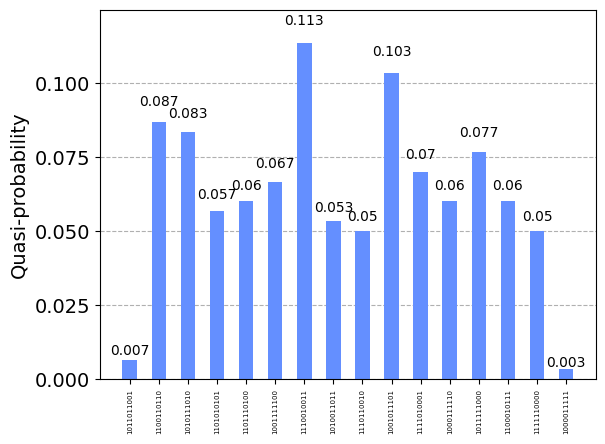

In [70]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution(samples, problem='clustering')

In [71]:
test_data['QA_Optimal_Solution_MKP'] = clusters[1]
test_data['QA_Optimal_Solution_MKP_is_valid_clustering'] = clusters[0]
test_data['QA_Optimal_Objective_MKP'] = obj
test_data['QA_Execution_Time_MKP'] = end_time - start_time
if solver=='Advantage_system6.2':
  test_data['QA_QPU_Access_Time_MKP'] = sampleset.info['timing']['qpu_access_time']

### Solve QUBO via Numpy Exact Solver

In [72]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q, offset)

# Numpy Exact Solver
numpy_solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(numpy_solver)
result = optimizer.solve(qp)
ref_value = result.fval
print('optimal objective value: ', ref_value, '\n', 'optimal solution: ', result.x)

optimal objective value:  120.0 
 optimal solution:  [1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.]


In [73]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

is_valid_clustering(clusters)

(True, [[0, 2, 3], [4, 1, 0]])

### Solve QUBO via VQE

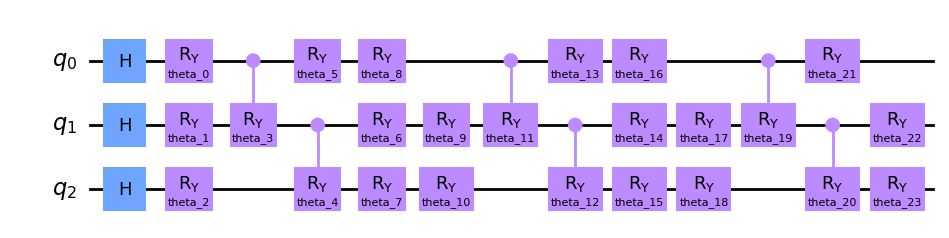

In [74]:
def build_ansatz_circuit(num_qubits, num_layers):

  # instantiate the circuit
  qc = QuantumCircuit(num_qubits)
  theta_idx = 0  # Initialize theta_idx to zero

  # Step 1: Apply Hadamard gates to all qubits
  qc.h(range(num_qubits))

  # Step 2, 3, and 4: Apply RY rotations and linear entanglement in each layer
  for layer in range(num_layers):
    # Apply RY rotations to each qubit in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply linear entanglement using Controlled-RY gates in the current layer
    for qubit in range(num_qubits - 1):
        control_qubit = qubit
        target_qubit = qubit + 1
        theta = Parameter(f'theta_{theta_idx}')
        qc.cry(theta, control_qubit, target_qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply RY rotations to each qubit again in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

  return qc

ansatz_circuit = build_ansatz_circuit(3, 3)

ansatz_circuit.draw(output='mpl')

In [75]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q, offset)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
# num_iter = 125
# cl_opt_index = 11
classic_optimizer = classic_optimizers[cl_opt_index](maxiter=num_iter)

# max_depth = 3
circuit_depth = 0

start_time = now()
while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  # Define VQE ansatz
  # ansatz = RealAmplitudes(len(qp.variables), entanglement='full', reps=circuit_depth)  # Adjust the number of repetitions (p) as needed
  ansatz = build_ansatz_circuit(len(qp.variables), num_layers=circuit_depth)  # Adjust the number of layers as needed

  if circuit_depth==1:
    initial_point = np.random.uniform(low=-2*np.pi, high=2*np.pi, size=ansatz.num_parameters)

  # Run VQE optimization
  vqe = SamplingVQE(qiskit_sampler, ansatz=ansatz, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(vqe)
  result = optimizer.solve(qp)

  # define new set of parameters
  # new_params = list(np.random.uniform(low=-2*np.pi, high=2*np.pi, size=2*len(qp.variables) + len(qp.variables)-1))
  new_params = list(np.random.choice(a=best_params, size=2*len(qp.variables) + len(qp.variables)-1))

  # print(len(best_params), len(new_params))

  # define new set of initial parameters
  initial_point = best_params + new_params

end_time = now()
print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  764*s[0][0]*s[0][1] + 382*s[0][0]*s[0][2] + 382*s[0][0]*z[0,2]
  + 382*s[0][0]*z[0,3] + 382*s[0][0]*z[0,4] + 764*s[0][1]*s[0][2]
  + 764*s[0][1]*z[0,3] + 764*s[0][1]*z[0,4] + 382*s[1][0]*z[1,2]
  + 764*s[1][1]*s[1][0] + 764*s[1][1]*z[1,2] + 764*s[1][1]*z[1,3]
  + 382*s[1][2]*s[1][0] + 764*s[1][2]*s[1][1] + 382*s[1][2]*z[1,1]
  + 382*s[1][2]*z[1,2] + 382*s[1][2]*z[1,3] + 20*z[0,0]*z[0,2]
  + 20*z[0,0]*z[0,3] + 26*z[0,0]*z[0,4] + 382*z[0,0]*z[1,0] + 382*z[0,1]*s[0][0]
  + 764*z[0,1]*s[0][1] + 382*z[0,1]*s[0][2] + 32*z[0,1]*z[0,0]
  + 400*z[0,1]*z[0,2] + 394*z[0,1]*z[0,3] + 388*z[0,1]*z[0,4]
  + 382*z[0,1]*z[1,1] + 764*z[0,2]*s[0][1] + 382*z[0,2]*s[0][2]
  + 398*z[0,2]*z[0,3] + 402*z[0,2]*z[0,4] + 382*z[0,2]*z[1,2]
  + 382*z[0,3]*s[0][2] + 382*z[0,4]*s[0][2] + 402*z[0,4]*z[0,3]
  + 20*z[1,0]*z[1,2] + 382*z[1,1]*s[1][0] + 764*z[1,1]*s[1][1]
  + 32*z[1,1]*z[1,0] + 400*z[1,1]*z[1,2] + 394*z[1,1]*z[1,3]
  + 382*z[1,3]*s[1][0] + 382*z[1,3]*z[0,3] + 20*z[1,3]*z[1,0]
 

In [76]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

vqe_clusters = is_valid_clustering(clusters)
print(vqe_clusters)
vqe_clusters = vqe_clusters[1]

(True, [[1, 0, 2], [4, 3, 0]])


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Convergence')

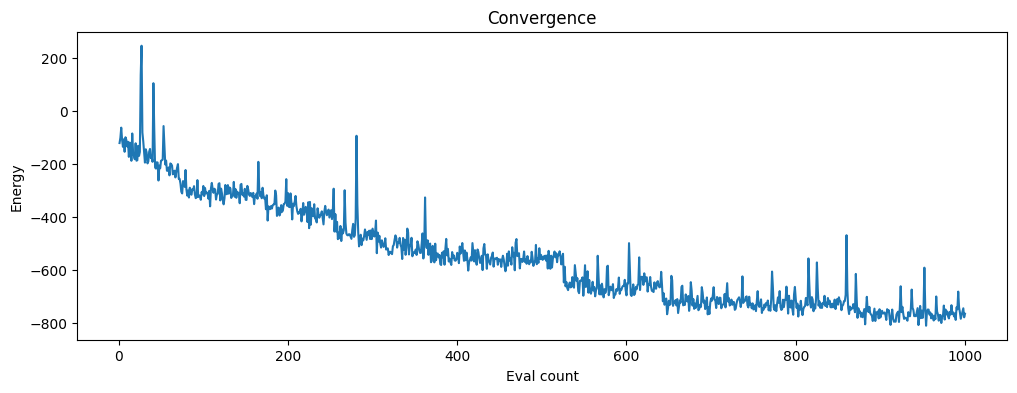

In [77]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

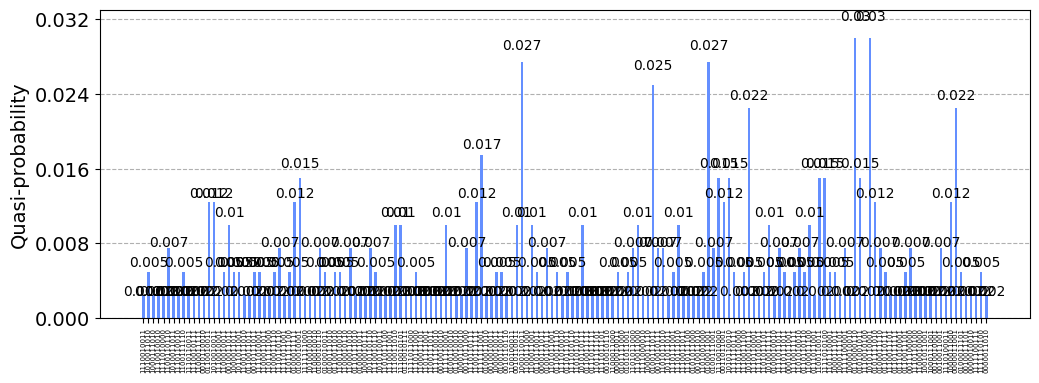

In [78]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [79]:
test_data['VQE_Optimal_Solution_MKP'] = is_valid_clustering(clusters)[1]
test_data['VQE_Optimal_Solution_MKP_is_valid_clustering'] = is_valid_clustering(clusters)[0]
test_data['VQE_Optimal_Objective_MKP'] = result.fval.real
test_data['VQE_Classical_Optimizer_MKP'] = cl_opt_names[cl_opt_index]
test_data['VQE_Classical_Optimizer_MKP_Num_Iter'] = num_iter
test_data['VQE_Circuit_Depth_MKP'] = max_depth
test_data['VQE_Execution_Time_MKP'] = end_time-start_time

In [80]:
# # print the Ansatz (smaller version for better visualization)
# ansatz = RealAmplitudes(3, entanglement='full', reps=2)
# ansatz.decompose().draw(output='mpl')

In [81]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==237.0])

### Solve QUBO via QAOA

In [82]:
# ################################ WARM-START QAOA ###############################

# # Retrieve Quadratic Program from QUBO
# qp = QUBO_to_QuadProg(Q)

# # print Quadratic Program
# print(qp.prettyprint())

# # Choose the classical optimizer
# classic_optimizer = SPSA(maxiter=125)

# # define the depth of the circuit
# circuit_depth = 1

# # Lists used in callback function to print the optimization progress
# counts_callback, values_callback = [], []
# # reset callback
# best_params = None
# best_evaluation = float('inf')

# # Run Warm-Start QAOA using Cobyla to presolve continuous relaxation of QUBO
# qaoa_mes = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result)
# ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0)
# ws_result = ws_qaoa.solve(qp)
# print(ws_result.prettyprint())

In [83]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q, offset)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
# cl_opt_index = 11
# num_iter = 125
classic_optimizer = classic_optimizers[cl_opt_index](maxiter=num_iter)

# max_depth = 1
circuit_depth = 0

start_time = now()
while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  if circuit_depth==1:
    initial_point = np.random.uniform(low=0, high=2*np.pi, size=2)

  # Run QAOA optimization
  qaoa = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(qaoa)
  result = optimizer.solve(qp)

  # get gamma parameters
  gamma = best_params[::2]
  gamma.insert(0, 0)
  gamma.append(0)

  # get beta parameters
  beta = best_params[1::2]
  beta.insert(0, 0)
  beta.append(0)

  # define new gamma parameters by linearly interpolating previous gamma
  new_gamma = []
  for i in range(1, circuit_depth+2):
    new_gamma.append((i-1)/circuit_depth*gamma[i-1] + (circuit_depth-i+1)/circuit_depth*gamma[i])

  # define new beta parameters by linearly interpolating previous gamma
  new_beta = []
  for i in range(1, circuit_depth+2):
    new_beta.append((i-1)/circuit_depth*beta[i-1] + (circuit_depth-i+1)/circuit_depth*beta[i])

  initial_point = []
  for i in range(len(new_gamma)):
    initial_point.append(new_gamma[i])
    initial_point.append(new_beta[i])

end_time = now()
print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  764*s[0][0]*s[0][1] + 382*s[0][0]*s[0][2] + 382*s[0][0]*z[0,2]
  + 382*s[0][0]*z[0,3] + 382*s[0][0]*z[0,4] + 764*s[0][1]*s[0][2]
  + 764*s[0][1]*z[0,3] + 764*s[0][1]*z[0,4] + 382*s[1][0]*z[1,2]
  + 764*s[1][1]*s[1][0] + 764*s[1][1]*z[1,2] + 764*s[1][1]*z[1,3]
  + 382*s[1][2]*s[1][0] + 764*s[1][2]*s[1][1] + 382*s[1][2]*z[1,1]
  + 382*s[1][2]*z[1,2] + 382*s[1][2]*z[1,3] + 20*z[0,0]*z[0,2]
  + 20*z[0,0]*z[0,3] + 26*z[0,0]*z[0,4] + 382*z[0,0]*z[1,0] + 382*z[0,1]*s[0][0]
  + 764*z[0,1]*s[0][1] + 382*z[0,1]*s[0][2] + 32*z[0,1]*z[0,0]
  + 400*z[0,1]*z[0,2] + 394*z[0,1]*z[0,3] + 388*z[0,1]*z[0,4]
  + 382*z[0,1]*z[1,1] + 764*z[0,2]*s[0][1] + 382*z[0,2]*s[0][2]
  + 398*z[0,2]*z[0,3] + 402*z[0,2]*z[0,4] + 382*z[0,2]*z[1,2]
  + 382*z[0,3]*s[0][2] + 382*z[0,4]*s[0][2] + 402*z[0,4]*z[0,3]
  + 20*z[1,0]*z[1,2] + 382*z[1,1]*s[1][0] + 764*z[1,1]*s[1][1]
  + 32*z[1,1]*z[1,0] + 400*z[1,1]*z[1,2] + 394*z[1,1]*z[1,3]
  + 382*z[1,3]*s[1][0] + 382*z[1,3]*z[0,3] + 20*z[1,3]*z[1,0]
 

In [84]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

qaoa_clusters = is_valid_clustering(clusters)
print(qaoa_clusters)
qaoa_clusters = qaoa_clusters[1]

(True, [[0, 2], [4, 1, 3, 0]])


Text(0.5, 1.0, 'Convergence')

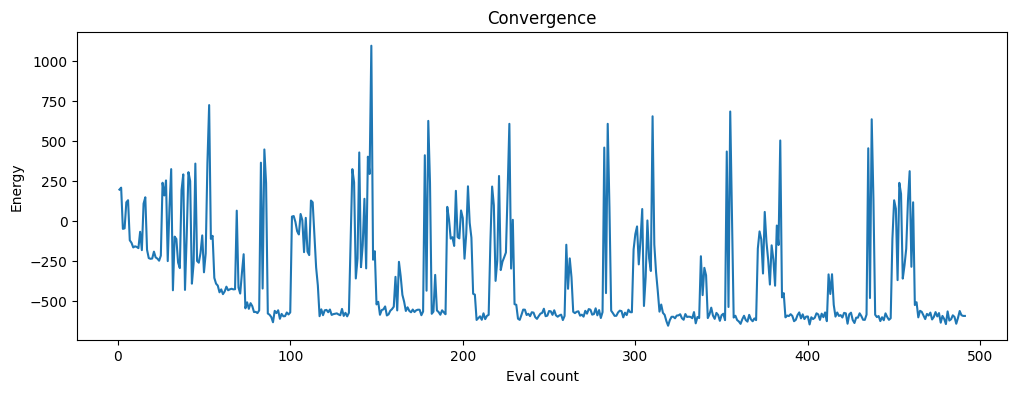

In [85]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

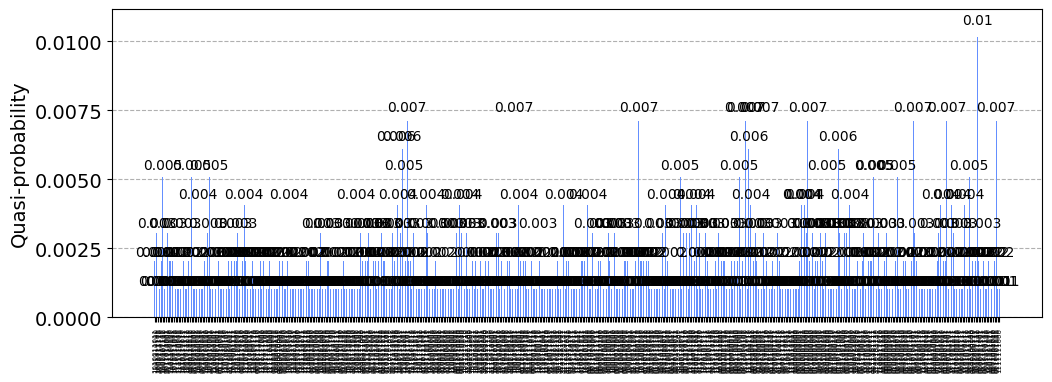

In [86]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [87]:
test_data['QAOA_Optimal_Solution_MKP'] = is_valid_clustering(clusters)[1]
test_data['QAOA_Optimal_Solution_MKP_is_valid_clustering'] = is_valid_clustering(clusters)[0]
test_data['QAOA_Optimal_Objective_MKP'] = result.fval.real
test_data['QAOA_Classical_Optimizer_MKP'] = cl_opt_names[cl_opt_index]
test_data['QAOA_Classical_Optimizer_MKP_Num_Iter'] = num_iter
test_data['QAOA_Circuit_Depth_MKP'] = max_depth
test_data['QAOA_Execution_Time_MKP'] = end_time-start_time

In [88]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==74.0])

## Graver Augmented Multiseed Algorithm

### Define decision variables

In [89]:
# use Gurobi and build the model by sequentially adding constraints
# After that we'll use gurobipy library to retrieve the constraint matrix

# Declare and initialize model
m = gp.Model('MKP_GAMA')

# Create edges variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# Create slack variables for capacity constraints
s = {}
for v in range(k):
  num_var_enc = int(np.ceil(np.log2(int(sum(d[1:]))+1)))
  for t in range(num_var_enc):
    s[(v,t)] = m.addVar(vtype=GRB.BINARY, name=f"s[{v},{t}]")

m.update()

### Define constraints

In [90]:
# depot must be in each knapsack
m.addConstr(sum(z[(v, 0)] for v in range(k)) == k, name='each_customer_to_one_vehicle')

# each object in exactly one knapsack (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(1, n)), name='each_customer_to_one_vehicle')

# the total demands of customer served by vehicle v cannot exceed the vehicle capacity
m.addConstrs((sum(d[i]*z[(v, i)] for i in range(1, n)) +
              (C - int(sum(d[1:])) + sum([2**t * s[(v,t)] for t in range(int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)]) +
              (int(sum(d[1:]))-sum([2**t for t in range(int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)]))
              *s[(v,int(np.ceil(np.log2(int(sum(d[1:]))+1)))-1)])   # s[v]
              == C for v in range(k)), name='vehicle_capacity')

# update model
m.update()

### Define objective

In [91]:
# Objective: minimize total cost of all assignments
obj = sum(E[i,j]*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)
              if i!=j and E[i,j]!=0)

m.setObjective(obj, GRB.MINIMIZE)

# update model
m.update()

### Optimize the model via Gurobi

In [92]:
# Save model for inspection
m.write('MKP_GAMA.lp')
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 16 columns and 24 nonzeros
Model fingerprint: 0xa21c2c02
Model has 20 quadratic objective terms
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 120.0000000
Presolve removed 7 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 120 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+02, best bound 1.200000000000e+02, gap 0.0000%

In [93]:
# get non zero decision variables (only x's)
clusters = []
for v in m.getVars():
  if v.varName[0]=='z' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_clustering(clusters)

(True, [[0, 2, 3], [0, 1, 4]])

### Retrieve constraint matrix

In [94]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()), int)

# create decision variables
num_var_enc = int(np.ceil(np.log2(int(sum(d[1:]))+1)))
x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

In [95]:
# Objective function definition
def f(x):
  y = x[:k*n, ]
  y = y.reshape((k, n))
  obj = sum(E[i,j]*y[v,i]*y[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)
              if i!=j and E[i,j]!=0)
  return obj

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [96]:
# # check gurobi solution
# var = np.array([v.x for v in m.getVars()])
# print(np.dot(A,var)-b) # feasibility
# print(np.dot(obj_coeffs, var)) # obj value

### Graver Augmentation

In [97]:
start_time = now()

# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

1  graver elements found.


In [98]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
print(len(feas_sols), ' feasible solutions found.')

50  feasible solutions found.


In [99]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]

end_time = now()

print(x_opt, np.min(final_obj_full))

[1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.] 120.0


In [100]:
clusters = []
for v in range(k):
  for i in range(n):
    clusters.append((v,i))

clusters = [clusters[i] for i in range(len(clusters)) if x_opt[i]>1e-6]

print(clusters)

gama_clusters = is_valid_clustering(clusters)
print(gama_clusters)
gama_clusters = gama_clusters[1]

[(0, 0), (0, 2), (0, 3), (1, 0), (1, 1), (1, 4)]
(True, [[0, 2, 3], [0, 1, 4]])


In [101]:
# quantum GAMA
test_data['QuGAMA_Optimal_Solution_MKP'] = is_valid_clustering(clusters)[1]
test_data['QuGAMA_Optimal_Solution_MKP_is_valid_clustering'] = is_valid_clustering(clusters)[0]
test_data['QuGAMA_Optimal_Objective_MKP'] = np.min(final_obj_full)
test_data['QuGAMA_Num_Graver_Basis_MKP'] = len(graver_elems)
test_data['QuGAMA_Num_Feasible_Sols_MKP'] = len(feas_sols)
test_data['QuGAMA_Execution_Time_MKP'] = end_time - start_time

# 2-Phase Heuristic: Clustering (Modularity Maximization)

## Formulation

\begin{alignat*}{2}
\text{Maximize} \quad & \frac{1}{m}\sum_{v}\sum_{i, j}\left[A_{ij}-\frac{d_i^{in}d_j^{out}}{m}\right]z_{v,i}z_{v,j} \\
\text{subject to} \quad & \sum_{v}z_{v,i}=1 \quad \forall i=0, \dots, n-1\\
& z_{v,i} \in \{0, 1\} \quad \forall v=0, \dots, k-1; \,\, i=0, \dots, n-1
\end{alignat*}

## Gurobi

In [102]:
# Declare and initialize model
m = gp.Model('Modularity_Maximization')

### Decision variables

In [103]:
# Create decision variables

# edge variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

# update model
m.update()

### Constraints

In [104]:
# each node must be in exactly one community
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(n)), name='each_node_to_one_cluster')

# update model
m.update()

### Objective function

In [105]:
def in_degree(node):
  return np.sum(E[:, node]>0)

def out_degree(node):
  return np.sum(E[node, :]>0)

num_edges = np.sum(E>0)

# Objective: maximize modularity
obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)

m.setObjective(obj, GRB.MAXIMIZE)

# update model
m.update()

### Optimize

In [106]:
# Save model for inspection
m.write('Modularity_Maximization.lp')

# Run optimization engine
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 5 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x6b843750
Model has 30 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.9947091
Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 11 columns, 18 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective -0.5149787

Root relaxation: objective -3.598547e-01, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

### Refine Clusters

In [107]:
# get customers
clusters = []
for v in m.getVars():
  if v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

gurobi_clusters_MM = is_valid_clustering(clusters)
gurobi_clusters_MM = gurobi_clusters_MM[1]
print(gurobi_clusters_MM)

[[1, 3, 4], [0, 2]]


In [108]:
# refine the clusters
gurobi_clusters_MM = check_capacity_constraints(G_inv, gurobi_clusters_MM)
gurobi_clusters_MM = check_depot_connection(G_inv, gurobi_clusters_MM)
for comm in gurobi_clusters_MM:
  if 0 not in comm:
    comm.append(0)
gurobi_clusters_MM

[[1, 3, 4, 0], [0, 2]]

In [109]:
test_data['Gurobi_Optimal_Solution_MM'] = is_valid_clustering_MM(gurobi_clusters_MM)[1]
test_data['Gurobi_Optimal_Solution_MM_is_valid_clustering'] = is_valid_clustering_MM(gurobi_clusters_MM)[0]
test_data['Gurobi_Optimal_Objective_MM'] = m.ObjVal
test_data['Gurobi_Execution_Time_MM'] = m.runtime

## QUBO

### Define the variables

In [110]:
# create QUBO variables for the edges
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = Binary(f'z[{v},{i}]')

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

### Build the matrix

In [111]:
# build QUBO by manually adding objective and constraints

# custom functions needed to compute modularity
def in_degree(node):
  return np.sum(E_inv[:, node]>0)
def out_degree(node):
  return np.sum(E_inv[node, :]>0)

# number of edges in the graph
num_edges = np.sum(E_inv>0)

# Objective: maximize modularity
obj = sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)

# add the objective
Q = -obj

# add the constraints
# each node assigned to exactly one cluster
Q += p*sum([Constraint((sum([z[(v, i)] for v in range(k)])-1)**2, label=f'assign_node_{i}') for i in range(n)])

In [112]:
# get QUBO matrix
model = Q.compile()
Q, offset = model.to_qubo()
Q

{('z[1,3]', 'z[0,3]'): 382.0,
 ('z[1,0]', 'z[1,0]'): -190.96,
 ('z[0,3]', 'z[0,0]'): 0.07999546000702376,
 ('z[0,0]', 'z[0,0]'): -190.96,
 ('z[1,4]', 'z[1,0]'): 0.07999977396705932,
 ('z[1,2]', 'z[0,2]'): 382.0,
 ('z[0,1]', 'z[0,1]'): -190.96,
 ('z[0,3]', 'z[0,3]'): -190.96,
 ('z[1,1]', 'z[1,0]'): 0.07999998874648254,
 ('z[0,3]', 'z[0,2]'): 0.07996645373720976,
 ('z[0,4]', 'z[0,1]'): 0.07502129316321361,
 ('z[0,3]', 'z[0,1]'): 0.07975212478233337,
 ('z[1,2]', 'z[1,1]'): 0.07998765901959135,
 ('z[1,4]', 'z[1,1]'): 0.07502129316321361,
 ('z[1,2]', 'z[1,2]'): -190.96,
 ('z[1,4]', 'z[1,2]'): 0.07999546000702376,
 ('z[1,4]', 'z[1,3]'): 0.07999546000702376,
 ('z[0,4]', 'z[0,2]'): 0.07999546000702376,
 ('z[0,2]', 'z[0,2]'): -190.96,
 ('z[1,1]', 'z[0,1]'): 382.0,
 ('z[0,4]', 'z[0,3]'): 0.07999546000702376,
 ('z[0,1]', 'z[0,0]'): 0.07999998874648254,
 ('z[1,4]', 'z[1,4]'): -190.96,
 ('z[0,4]', 'z[0,4]'): -190.96,
 ('z[0,2]', 'z[0,0]'): 0.07999546000702376,
 ('z[1,3]', 'z[1,1]'): 0.0797521247823

### D-Wave Embedding Info

In [113]:
# save num_variables in dataframe
G_qubo = nx.from_edgelist(Q)
test_data['Num_Qubits_MM'] = len(G_qubo.nodes)

# First of all let's take a look at the Minor-Embedding
if solver=='Advantage_system6.2':
  emb_info = DWave_embedding_info(Q, hardware_graph[1])
  # save in dataframe
  test_data['Num_Qubits_Embedding_MM'] = emb_info[1]
  test_data['Shortest_Chain_Length_MM'] = emb_info[2]
  test_data['Longest_Chain_Length_MM'] = emb_info[3]

### Solve QUBO via Quantum Annealing

In [114]:
start_time = now()
# solve the model with the chosen sampler
if solver=='SimulAnneal':   # classic solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, num_steps=1000)
elif solver=='hybrid_binary_quadratic_model_version2':    # hybrid solver
  sampleset = sampler.sample_qubo(Q)
elif solver=='Advantage_system6.2':   # quantum solver
  sampleset = sampler.sample_qubo(Q, num_reads=300, annealing_time=qpu.properties["annealing_time_range"][1])
end_time = now()

# get obtained solutions
samples = model.decode_sampleset(sampleset)

# take only feasible solutions (actual clusterings)
# samples = [s for s in samples if is_valid_clustering(get_clusters_from_sample(s.sample))[0]==True]

best_sample, energy = None, None

if len(samples)>0:
  # take only best solution (minimum energy)
  best_sample = min(samples, key=lambda s: s.energy)
  print(best_sample.sample, '\n', best_sample.energy)

{'z[1,4]': 0, 'z[1,1]': 0, 'z[1,0]': 1, 'z[0,4]': 1, 'z[0,2]': 0, 'z[0,1]': 1, 'z[1,3]': 0, 'z[1,2]': 1, 'z[0,3]': 1, 'z[0,0]': 0} 
 0.5147643379594911


In [115]:
# compute original objective function value in best_sample
z = {}

if best_sample != None:
  for v in range(k):
    for i in range(n):
      z[(v, i)] = best_sample.sample[f'z[{v},{i}]']

# original objective function value
obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)
print(-obj)

0.5147643379595945


In [116]:
# check if solution is a valid clustering
annealing_clusters_MM = is_valid_clustering(get_clusters_from_sample(best_sample.sample))
print(annealing_clusters_MM)
annealing_clusters_MM = annealing_clusters_MM[1]

(False, [[1, 3, 4], [0, 2]])


In [117]:
# refine the clusters
annealing_clusters_MM = check_capacity_constraints(G_inv, annealing_clusters_MM)
annealing_clusters_MM = check_depot_connection(G_inv, annealing_clusters_MM)
for comm in annealing_clusters_MM:
  if 0 not in comm:
    comm.append(0)
annealing_clusters_MM

[[1, 3, 4, 0], [0, 2]]

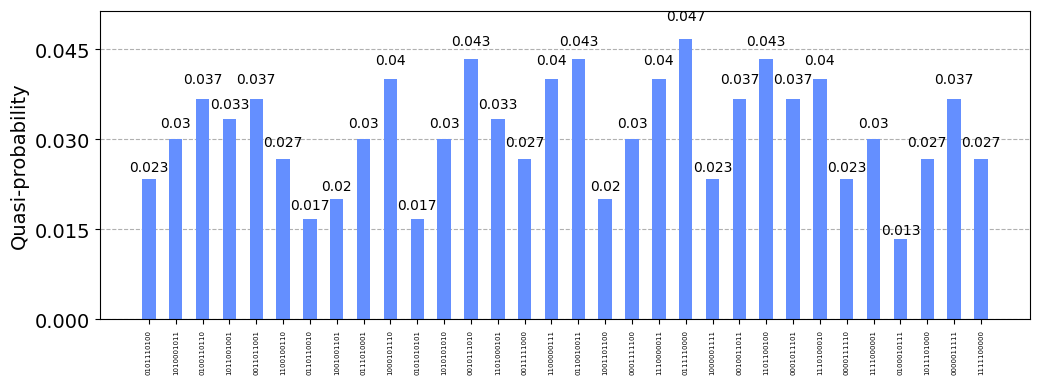

In [118]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution(samples, problem='clustering')

In [119]:
test_data['QA_Optimal_Solution_MM'] = is_valid_clustering_MM(annealing_clusters_MM)[1]
test_data['QA_Optimal_Solution_MM_is_valid_clustering'] = is_valid_clustering_MM(annealing_clusters_MM)[0]
test_data['QA_Optimal_Objective_MM'] = -obj
test_data['QA_Execution_Time_MM'] = end_time - start_time
if solver=='Advantage_system6.2':
  test_data['QA_QPU_Access_Time_MM'] = sampleset.info['timing']['qpu_access_time']

### Solve QUBO via Numpy Exact Solver

In [120]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q, offset)

# Numpy Exact Solver
numpy_solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(numpy_solver)
result = optimizer.solve(qp)
ref_value = result.fval
print('optimal objective value: ', ref_value, '\n', 'optimal solution: ', result.x)

optimal objective value:  0.5147643379595264 
 optimal solution:  [0. 1. 0. 0. 0. 1. 1. 0. 1. 1.]


In [121]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

is_valid_clustering(clusters)

(False, [[0, 2], [4, 3, 1]])

### Solve QUBO via VQE

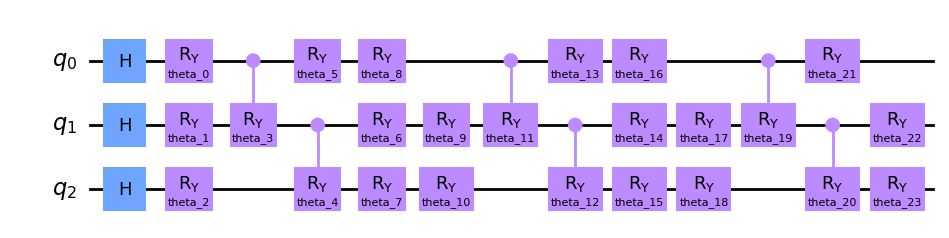

In [122]:
def build_ansatz_circuit(num_qubits, num_layers):

  # instantiate the circuit
  qc = QuantumCircuit(num_qubits)
  theta_idx = 0  # Initialize theta_idx to zero

  # Step 1: Apply Hadamard gates to all qubits
  qc.h(range(num_qubits))

  # Step 2, 3, and 4: Apply RY rotations and linear entanglement in each layer
  for layer in range(num_layers):
    # Apply RY rotations to each qubit in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply linear entanglement using Controlled-RY gates in the current layer
    for qubit in range(num_qubits - 1):
        control_qubit = qubit
        target_qubit = qubit + 1
        theta = Parameter(f'theta_{theta_idx}')
        qc.cry(theta, control_qubit, target_qubit)
        theta_idx += 1  # Increment theta_idx

    # Apply RY rotations to each qubit again in the current layer
    for qubit in range(num_qubits):
        theta = Parameter(f'theta_{theta_idx}')
        qc.ry(theta, qubit)
        theta_idx += 1  # Increment theta_idx

  return qc

ansatz_circuit = build_ansatz_circuit(3, 3)

ansatz_circuit.draw(output='mpl')

In [123]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q, offset)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
# cl_opt_index = 11
# num_iter = 125
classic_optimizer = classic_optimizers[cl_opt_index](maxiter=num_iter)

# max_depth = 3
circuit_depth = 0

start_time = now()
while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  # Define VQE ansatz
  # ansatz = RealAmplitudes(len(qp.variables), entanglement='full', reps=circuit_depth)  # Adjust the number of repetitions (p) as needed
  ansatz = build_ansatz_circuit(len(qp.variables), num_layers=circuit_depth)  # Adjust the number of layers as needed

  if circuit_depth==1:
    initial_point = np.random.uniform(low=-2*np.pi, high=2*np.pi, size=ansatz.num_parameters)

  # Run VQE optimization
  vqe = SamplingVQE(qiskit_sampler, ansatz=ansatz, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(vqe)
  result = optimizer.solve(qp)

  # define new set of parameters
  # new_params = list(np.random.uniform(low=-2*np.pi, high=2*np.pi, size=2*len(qp.variables) + len(qp.variables)-1))
  new_params = list(np.random.choice(a=best_params, size=2*len(qp.variables) + len(qp.variables)-1))

  # print(len(best_params), len(new_params))

  # define new set of initial parameters
  initial_point = best_params + new_params

end_time = now()
print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  0.07999998874648254*z[0,0]*z[0,1] + 0.07999546000702376*z[0,0]*z[0,2]
  + 0.07999546000702376*z[0,0]*z[0,3] + 0.07999977396705932*z[0,0]*z[0,4]
  + 0.07998765901959135*z[0,1]*z[0,2] + 0.07975212478233337*z[0,1]*z[0,3]
  + 0.07502129316321361*z[0,1]*z[0,4] + 382*z[0,1]*z[1,1]
  + 0.07999546000702376*z[0,2]*z[0,4] + 0.07996645373720976*z[0,3]*z[0,2]
  + 0.07999546000702376*z[0,3]*z[0,4] + 382*z[0,3]*z[1,3] + 382*z[1,0]*z[0,0]
  + 0.07999998874648254*z[1,0]*z[1,1] + 0.07999546000702376*z[1,0]*z[1,2]
  + 0.07999546000702376*z[1,0]*z[1,3] + 0.07999977396705932*z[1,0]*z[1,4]
  + 382*z[1,2]*z[0,2] + 0.07998765901959135*z[1,2]*z[1,1]
  + 0.07996645373720976*z[1,2]*z[1,3] + 0.07999546000702376*z[1,2]*z[1,4]
  + 0.07975212478233337*z[1,3]*z[1,1] + 382*z[1,4]*z[0,4]
  + 0.07502129316321361*z[1,4]*z[1,1] + 0.07999546000702376*z[1,4]*z[1,3]
  - 190.96*z[0,0] - 190.96*z[0,1] - 190.96*z[0,2] - 190.96*z[0,3]
  - 190.96*z[0,4] - 190.96*z[1,0] - 190.96*z[1,1] - 190.96*z[1,2]
 

In [124]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

vqe_clusters_MM = is_valid_clustering(clusters)
print(vqe_clusters_MM)
vqe_clusters_MM = vqe_clusters_MM[1]

(False, [[1, 3, 4], [0, 2]])


In [125]:
# refine the clusters
vqe_clusters_MM = check_capacity_constraints(G_inv, vqe_clusters_MM)
vqe_clusters_MM = check_depot_connection(G_inv, vqe_clusters_MM)
for comm in vqe_clusters_MM:
  if 0 not in comm:
    comm.append(0)
vqe_clusters_MM

[[1, 3, 4, 0], [0, 2]]

Text(0.5, 1.0, 'Convergence')

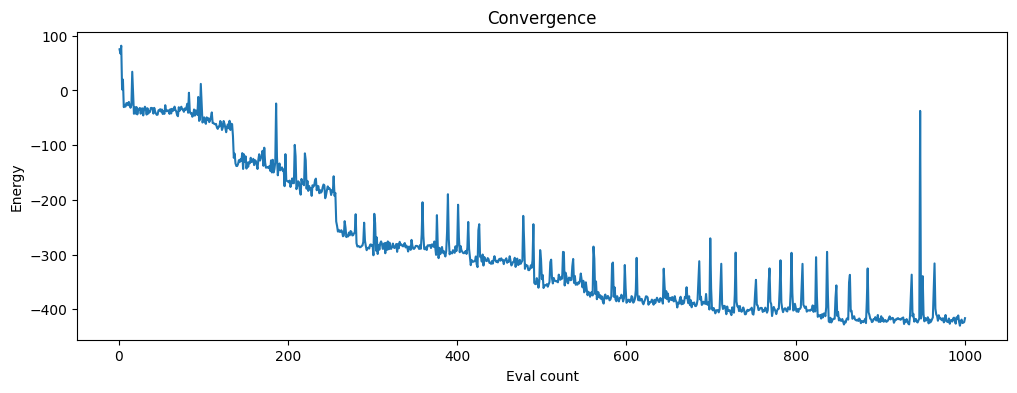

In [126]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

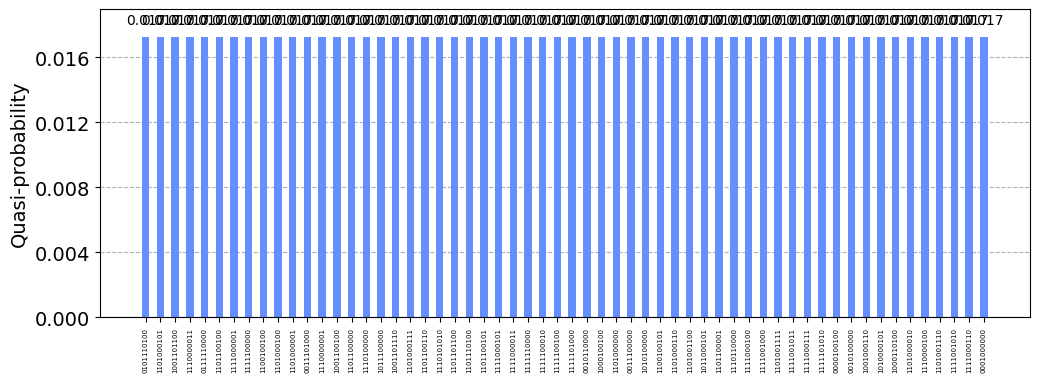

In [127]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [128]:
test_data['VQE_Optimal_Solution_MM'] = is_valid_clustering_MM(vqe_clusters_MM)[1]
test_data['VQE_Optimal_Solution_MM_is_valid_clustering'] = is_valid_clustering_MM(vqe_clusters_MM)[0]
test_data['VQE_Optimal_Objective_MM'] = result.fval.real
test_data['VQE_Classical_Optimizer_MM'] = cl_opt_names[cl_opt_index]
test_data['VQE_Classical_Optimizer_MM_Num_Iter'] = num_iter
test_data['VQE_Circuit_Depth_MM'] = max_depth
test_data['VQE_Execution_Time_MM'] = end_time-start_time

In [129]:
# # print the Ansatz (smaller version for better visualization)
# ansatz = RealAmplitudes(3, entanglement='full', reps=2)
# ansatz.decompose().draw(output='mpl')

In [130]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==237.0])

### Solve QUBO via QAOA

In [131]:
# Retrieve Quadratic Program from QUBO
qp = QUBO_to_QuadProg(Q, offset)

# print Quadratic Program
print(qp.prettyprint())

# Choose the classical optimizer
# cl_opt_index = 11
# num_iter = 125
classic_optimizer = classic_optimizers[cl_opt_index](maxiter=num_iter)

# max_depth = 1
circuit_depth = 0

start_time = now()
while circuit_depth < max_depth:

  # increase circuit depth
  circuit_depth += 1
  print('current circuit depth: ', circuit_depth)

  # Lists used in callback function to print the optimization progress
  counts_callback, values_callback = [], []
  # reset callback
  best_params = None
  best_evaluation = float('inf')

  if circuit_depth==1:
    initial_point = np.random.uniform(low=0, high=2*np.pi, size=2)

  # Run QAOA optimization
  qaoa = QAOA(qiskit_sampler, reps=circuit_depth, optimizer=classic_optimizer, callback=store_intermediate_result, initial_point=initial_point)
  optimizer = MinimumEigenOptimizer(qaoa)
  result = optimizer.solve(qp)

  # get gamma parameters
  gamma = best_params[::2]
  gamma.insert(0, 0)
  gamma.append(0)

  # get beta parameters
  beta = best_params[1::2]
  beta.insert(0, 0)
  beta.append(0)

  # define new gamma parameters by linearly interpolating previous gamma
  new_gamma = []
  for i in range(1, circuit_depth+2):
    new_gamma.append((i-1)/circuit_depth*gamma[i-1] + (circuit_depth-i+1)/circuit_depth*gamma[i])

  # define new beta parameters by linearly interpolating previous gamma
  new_beta = []
  for i in range(1, circuit_depth+2):
    new_beta.append((i-1)/circuit_depth*beta[i-1] + (circuit_depth-i+1)/circuit_depth*beta[i])

  initial_point = []
  for i in range(len(new_gamma)):
    initial_point.append(new_gamma[i])
    initial_point.append(new_beta[i])

end_time = now()
print('optimal objective value: ', result.fval.real, '\n', 'optimal solution: ', result.x)
print(f"Final Energy: {result.fval.real:.5f}")
print(f"Delta from reference energy value is {(result.fval.real - ref_value):.5f}")

Problem name: 

Minimize
  0.07999998874648254*z[0,0]*z[0,1] + 0.07999546000702376*z[0,0]*z[0,2]
  + 0.07999546000702376*z[0,0]*z[0,3] + 0.07999977396705932*z[0,0]*z[0,4]
  + 0.07998765901959135*z[0,1]*z[0,2] + 0.07975212478233337*z[0,1]*z[0,3]
  + 0.07502129316321361*z[0,1]*z[0,4] + 382*z[0,1]*z[1,1]
  + 0.07999546000702376*z[0,2]*z[0,4] + 0.07996645373720976*z[0,3]*z[0,2]
  + 0.07999546000702376*z[0,3]*z[0,4] + 382*z[0,3]*z[1,3] + 382*z[1,0]*z[0,0]
  + 0.07999998874648254*z[1,0]*z[1,1] + 0.07999546000702376*z[1,0]*z[1,2]
  + 0.07999546000702376*z[1,0]*z[1,3] + 0.07999977396705932*z[1,0]*z[1,4]
  + 382*z[1,2]*z[0,2] + 0.07998765901959135*z[1,2]*z[1,1]
  + 0.07996645373720976*z[1,2]*z[1,3] + 0.07999546000702376*z[1,2]*z[1,4]
  + 0.07975212478233337*z[1,3]*z[1,1] + 382*z[1,4]*z[0,4]
  + 0.07502129316321361*z[1,4]*z[1,1] + 0.07999546000702376*z[1,4]*z[1,3]
  - 190.96*z[0,0] - 190.96*z[0,1] - 190.96*z[0,2] - 190.96*z[0,3]
  - 190.96*z[0,4] - 190.96*z[1,0] - 190.96*z[1,1] - 190.96*z[1,2]
 

In [132]:
clusters = []
for i in range(len(result.x)):
  if result.x[i]>0 and qp.variables[i].name[0]=='z':
    vehicle_node = re.findall(r'\d+', qp.variables[i].name)
    clusters.append((int(vehicle_node[0]), int(vehicle_node[1])))

qaoa_clusters_MM = is_valid_clustering(clusters)
print(qaoa_clusters_MM)
qaoa_clusters_MM = qaoa_clusters_MM[1]

(False, [[0, 2], [4, 3, 1]])


In [133]:
# refine the clusters
qaoa_clusters_MM = check_capacity_constraints(G_inv, qaoa_clusters_MM)
qaoa_clusters_MM = check_depot_connection(G_inv, qaoa_clusters_MM)
for comm in qaoa_clusters_MM:
  if 0 not in comm:
    comm.append(0)
qaoa_clusters_MM

[[0, 2], [4, 3, 1, 0]]

Text(0.5, 1.0, 'Convergence')

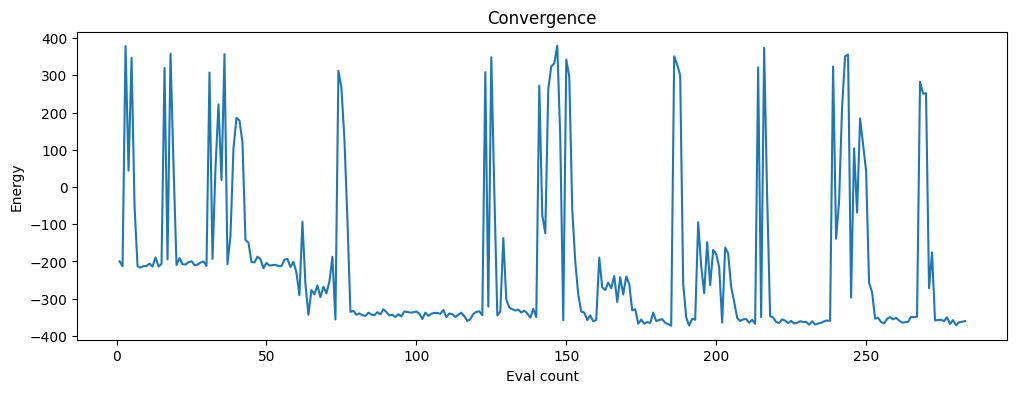

In [134]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_callback, values_callback)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence")

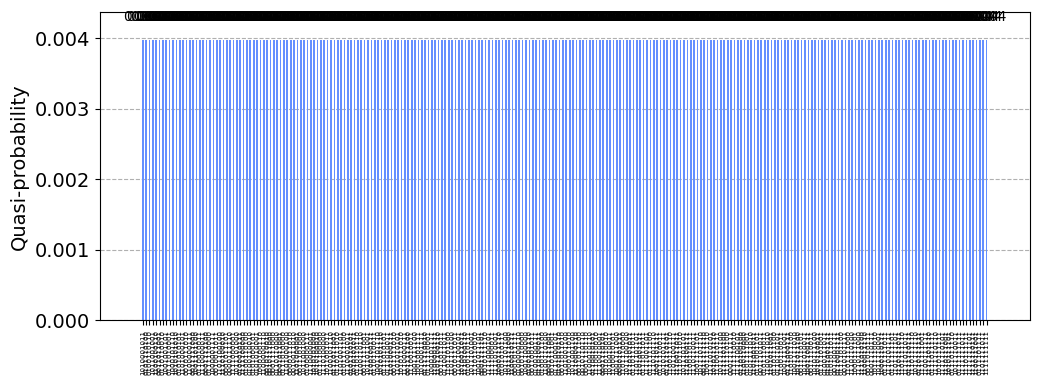

In [135]:
# plot solutions distribution among feasible solutions
plot_solutions_distribution_VQA(qp, result, problem='clustering')

In [136]:
test_data['QAOA_Optimal_Solution_MM'] = is_valid_clustering_MM(qaoa_clusters_MM)[1]
test_data['QAOA_Optimal_Solution_MM_is_valid_clustering'] = is_valid_clustering_MM(qaoa_clusters_MM)[0]
test_data['QAOA_Optimal_Objective_MM'] = result.fval.real
test_data['QAOA_Classical_Optimizer_MM'] = cl_opt_names[cl_opt_index]
test_data['QAOA_Classical_Optimizer_MM_Num_Iter'] = num_iter
test_data['QAOA_Circuit_Depth_MM'] = max_depth
test_data['QAOA_Execution_Time_MM'] = end_time-start_time

In [137]:
# samples = []
# probabilities = []
# fval = []
# for s in result.samples:
#   x = ''
#   for v in range(k):
#     for i in range(n):
#       x += str(int(s.x[qp.variables_index[f'z[{v},{i}]']]))
#   samples.append(x)
#   probabilities.append(s.probability)
#   fval.append(s.fval)

# sum([probabilities[i] for i in range(len(samples)) if fval[i]==74.0])

## Graver Augmented Multiseed Algorithm

### Define decision variables

In [138]:
# use Gurobi and build the model by sequentially adding constraints
# After that we'll use gurobipy library to retrieve the constraint matrix

# Declare and initialize model
m = gp.Model('Modularity_Maximization_GAMA')

# Create edges variables
z = {}
for v in range(k):
  for i in range(n):
    z[(v,i)] = m.addVar(vtype=GRB.BINARY, name=f"z[{v},{i}]")

m.update()

### Define constraints

In [139]:
# each node in exactly one cluster (each customer served by exactly one vehicle)
m.addConstrs((sum(z[(v, i)] for v in range(k)) == 1 for i in range(n)), name='each_node_to_one_cluster')

# update model
m.update()

### Define objective

In [140]:
# Objective: maximize modularity
obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*z[v,i]*z[v,j]
              for i in range(n)
              for j in range(n)
              for v in range(k)])*(1/num_edges)

m.setObjective(obj, GRB.MAXIMIZE)

# update model
m.update()

### Optimize the model via Gurobi

In [141]:
# Save model for inspection
m.write('Modularity_Maximization_GAMA.lp')
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 5 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x6b843750
Model has 30 quadratic objective terms
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.9947091
Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 11 columns, 18 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective -0.5149787

Root relaxation: objective -3.598547e-01, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

In [142]:
# get non zero decision variables (only x's)
clusters = []
for v in m.getVars():
  if v.varName[0]=='z' and v.x > 1e-6:
    nodes_indices = re.findall(r'\d+', v.varName)
    clusters.append((int(nodes_indices[0]), int(nodes_indices[1])))

is_valid_clustering(clusters)

(False, [[1, 3, 4], [0, 2]])

### Retrieve constraint matrix

In [143]:
# Get the constraint matrix A and vector b (Ax=b) from Gurobi model
m.update()
# x = m.getVars()
A = m.getA()
A = A.toarray()
b = np.array(m.getAttr("RHS", m.getConstrs()), int)

# create decision variables
x = Array.create('x', shape=(A.shape[1]), vartype='BINARY')

In [144]:
# Objective function definition
def f(x):
  y = x[:k*n, ]
  y = y.reshape((k, n))
  # Objective: maximize modularity
  obj = np.sum([(E_inv[i,j]-(in_degree(i)*out_degree(j)/num_edges))*y[v,i]*y[v,j]
                for i in range(n)
                for j in range(n)
                for v in range(k)])*(1/num_edges)
  return -obj

# Constraints satisfaction
def const(x):
    return np.array_equiv(np.dot(A,x),b.T) or np.array_equiv(np.dot(A,x),b)

In [145]:
# # check gurobi solution
# var = np.array([v.x for v in m.getVars()])
# print(np.dot(A,var)-b) # feasibility
# print(np.dot(obj_coeffs, var)) # obj value

### Graver Augmentation

In [146]:
start_time = now()

# compute graver basis elements
graver_elems = get_feasible(A, np.zeros_like(b), sampler=sampler, samples=100, refine_almost_feasible=True)
print(len(graver_elems), ' graver elements found.')

1  graver elements found.


In [147]:
# compute feasible solutions
feas_sols = get_feasible(A, b, sampler=sampler, samples=100)
print(len(feas_sols), ' feasible solutions found.')

30  feasible solutions found.


In [148]:
# Multiseed Augmentation
final_sols, final_obj_full = graver_multiseed_augmentation(feas_sols, graver_elems, const, f)

# get best solution
x_opt = final_sols[np.argmin(final_obj_full), :]

end_time = now()

print(x_opt, np.min(final_obj_full))

[0. 1. 0. 1. 1. 1. 0. 1. 0. 0.] 0.5147643379595945


In [149]:
clusters = []
for v in range(k):
  for i in range(n):
    clusters.append((v,i))

clusters = [clusters[i] for i in range(len(clusters)) if x_opt[i]>1e-6]

print(clusters)

gama_clusters_MM = is_valid_clustering(clusters)
print(gama_clusters_MM)
gama_clusters_MM = gama_clusters_MM[1]

[(0, 1), (0, 3), (0, 4), (1, 0), (1, 2)]
(False, [[1, 3, 4], [0, 2]])


In [150]:
# refine the clusters
gama_clusters_MM = check_capacity_constraints(G_inv, gama_clusters_MM)
gama_clusters_MM = check_depot_connection(G_inv, gama_clusters_MM)
for comm in gama_clusters_MM:
  if 0 not in comm:
    comm.append(0)
gama_clusters_MM

[[1, 3, 4, 0], [0, 2]]

In [151]:
# quantum GAMA
test_data['QuGAMA_Optimal_Solution_MM'] = is_valid_clustering_MM(gama_clusters_MM)[1]
test_data['QuGAMA_Optimal_Solution_MM_is_valid_clustering'] = is_valid_clustering_MM(gama_clusters_MM)[0]
test_data['QuGAMA_Optimal_Objective_MM'] = np.min(final_obj_full)
test_data['QuGAMA_Num_Graver_Basis_MM'] = len(graver_elems)
test_data['QuGAMA_Num_Feasible_Sols_MM'] = len(feas_sols)
test_data['QuGAMA_Execution_Time_MM'] = end_time - start_time

# 2-Phase Heuristic: Routing (Travelling Salesman Problem - MKP Clusters)

In [152]:
cl_opt_index = 3
num_iter = 300
max_depth = 1

## Formulation with DFJ Method for sequential subtour elimination

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i \in Cluster\\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j \in Cluster\\
& \sum_{i \in S} \sum_{j \notin S} x_{ij} \geq 1 \quad \forall S \;\;\text{subtour}\\
& x_{ij} \in \{0, 1\} \quad \forall i,j \in Cluster
\end{alignat*}

In [153]:
# available clusters
clusters_dict = {
    'gurobi_MKP' : gurobi_clusters,
    'gurobi_MM' : gurobi_clusters_MM,

    'annealing_MKP' : annealing_clusters,
    'annealing_MM' : annealing_clusters_MM,

    'vqe_MKP' : vqe_clusters,
    'vqe_MM' : vqe_clusters_MM,

    'qaoa_MKP' : qaoa_clusters,
    'qaoa_MM' : qaoa_clusters_MM,

    'gama_MKP' : gama_clusters,
    'gama_MM' : gama_clusters_MM,

    '_louvain' : louvain_clusters
}

clusters_str = '_MKP'

## Gurobi

In [154]:
clusters = clusters_dict['gurobi'+ clusters_str]
test_data['Gurobi_Execution_Time_TSP'+clusters_str] = 0

# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gurobi(cluster, clusters_str=clusters_str)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 6 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x825fb3b9
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 28 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|

In [155]:
results = list(tsp_solutions.values())
print(results)
test_data['Gurobi_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])

[([(0, 2), (2, 3), (3, 0)], 28.0), ([(0, 1), (1, 4), (4, 0)], 32.0)]


## QUBO

### Quantum Annealing

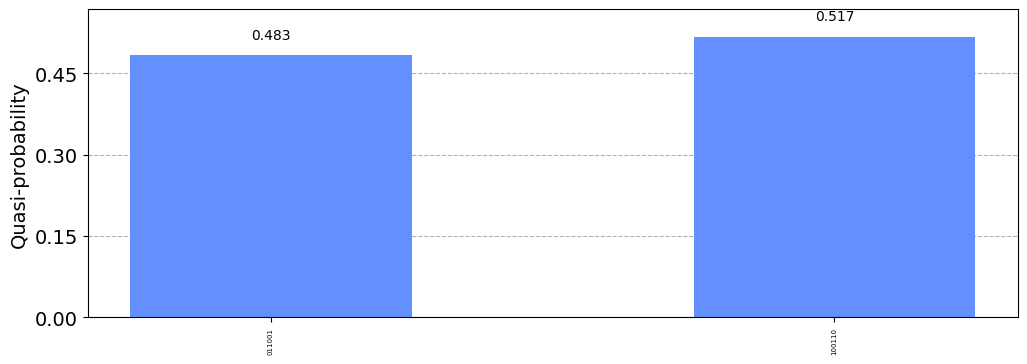

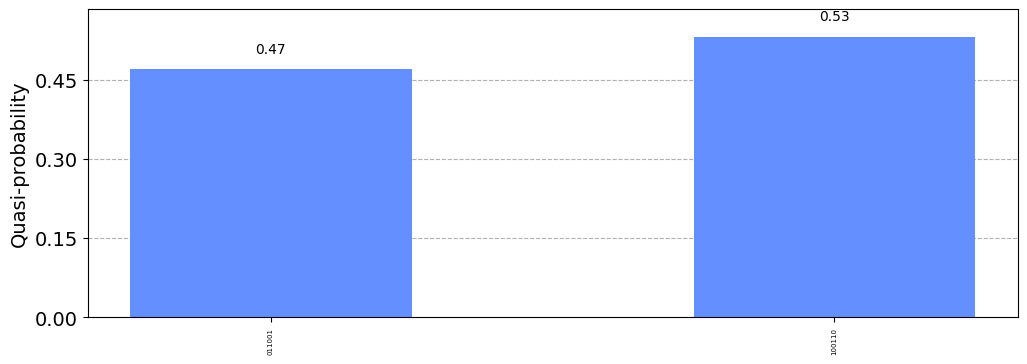

In [156]:
test_data['QA_QPU_Access_Time_TSP'+clusters_str] = 0
test_data['Max_Num_Qubits_TSP'+clusters_str] = []
if solver=='Advantage_system6.2':
  test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str] = []
  test_data['Shortest_Chain_Length_TSP'+clusters_str] = []
  test_data['Longest_Chain_Length_TSP'+clusters_str] = []

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)
clusters = clusters_dict['annealing'+clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo(cluster, p, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [157]:
results = list(tsp_solutions.values())
print(results)
test_data['QA_Execution_Time_TSP'+clusters_str] = end_time - start_time
test_data['QA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['Max_Num_Qubits_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Max_Num_Qubits_TSP'+clusters_str]])
if solver=='Advantage_system6.2':
  test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str]])
  test_data['Shortest_Chain_Length_TSP'+clusters_str] = np.min([num_qubits for num_qubits in test_data['Shortest_Chain_Length_TSP'+clusters_str]])
  test_data['Longest_Chain_Length_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Longest_Chain_Length_TSP'+clusters_str]])

[([(0, 3), (2, 0), (3, 2)], 28), ([(0, 4), (1, 0), (4, 1)], 32)]


### VQE

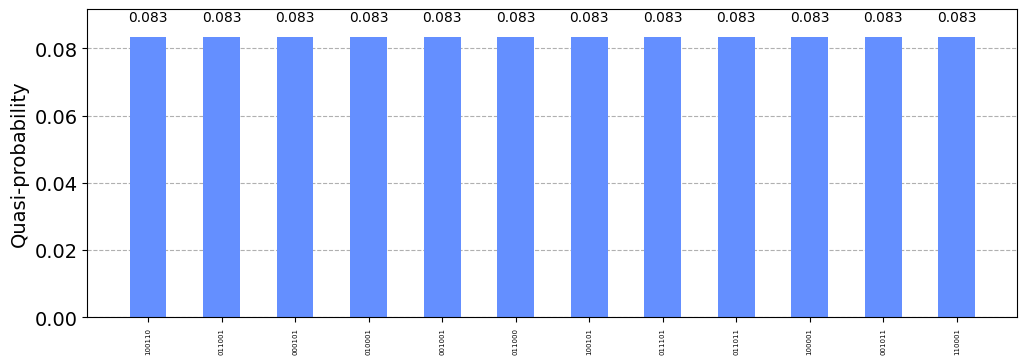

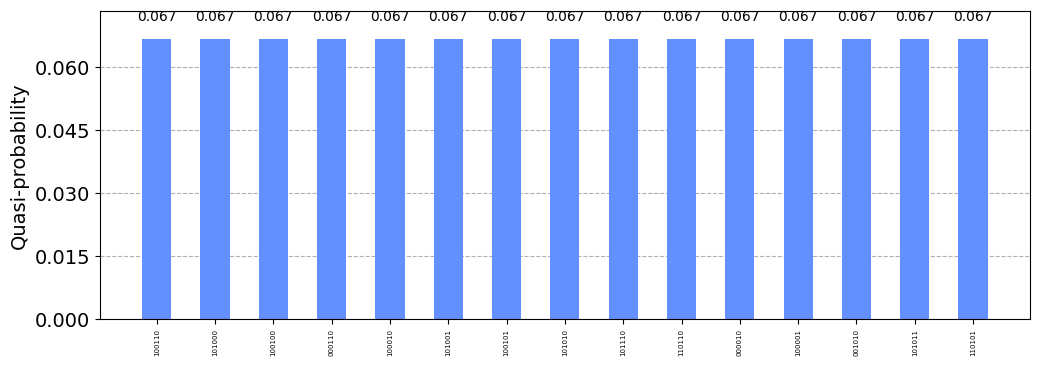

In [158]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

clusters = clusters_dict['vqe'+clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
# cl_opt_index = 11
# num_iter = 125
# max_depth = 1
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='VQE', cl_opt_index=cl_opt_index,
                                                   circuit_depth=max_depth, num_iter=num_iter, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [159]:
results = list(tsp_solutions.values())
print(results)
test_data['VQE_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['VQE_Classical_Optimizer_TSP'+clusters_str] = cl_opt_names[cl_opt_index]
test_data['VQE_Classical_Optimizer_TSP_Num_Iter'+clusters_str] = num_iter
test_data['VQE_Circuit_Depth_TSP'+clusters_str] = max_depth
test_data['VQE_Execution_Time_TSP'+clusters_str] = end_time-start_time

[([(0, 1), (1, 2), (2, 0)], 35.0), ([(0, 3), (3, 4), (4, 0)], 33.0)]


### QAOA

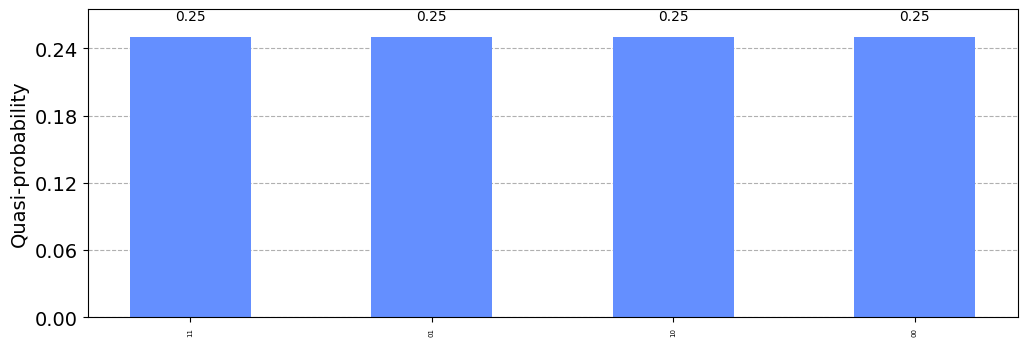

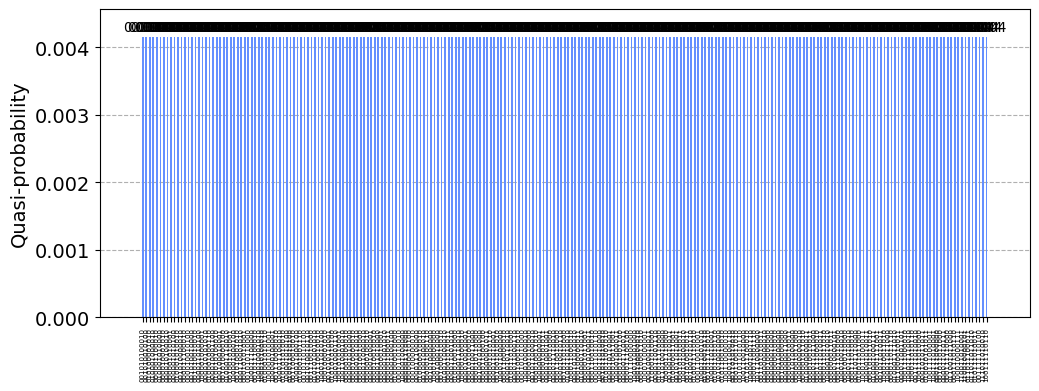

In [160]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

clusters = clusters_dict['qaoa'+clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
# cl_opt_index = 11
# num_iter = 125
# max_depth = 1
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='QAOA', cl_opt_index=cl_opt_index,
                                                   circuit_depth=max_depth, num_iter=num_iter, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [161]:
results = list(tsp_solutions.values())
print(results)
test_data['QAOA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['QAOA_Classical_Optimizer_TSP'+clusters_str] = cl_opt_names[cl_opt_index]
test_data['QAOA_Classical_Optimizer_TSP_Num_Iter'+clusters_str] = num_iter
test_data['QAOA_Circuit_Depth_TSP'+clusters_str] = max_depth
test_data['QAOA_Execution_Time_TSP'+clusters_str] = end_time-start_time

[([(0, 2), (2, 0)], 20.0), ([(0, 4), (1, 3), (3, 0), (4, 1)], 32.0)]


## Graver Augmented Multiseed Algorithm

In [162]:
test_data_gama = {}
test_data_gama['QuGAMA_Num_Graver_Basis_TSP'] = []
test_data_gama['QuGAMA_Num_Feasible_Sols_TSP'] = []

clusters = clusters_dict['gama'+clusters_str]

# solve TSP individually on each cluster
tsp_solutions = {}
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gama(cluster, clusters_str)
end_time = now()

In [163]:
results = list(tsp_solutions.values())
print(results)
test_data['QuGAMA_Execution_Time_TSP'+clusters_str] = end_time - start_time
test_data['QuGAMA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['QuGAMA_Min_Num_Graver_Basis_TSP'+clusters_str] = np.min([el for el in test_data_gama['QuGAMA_Num_Graver_Basis_TSP']])
test_data['QuGAMA_Max_Num_Graver_Basis_TSP'+clusters_str] = np.max([el for el in test_data_gama['QuGAMA_Num_Graver_Basis_TSP']])
test_data['QuGAMA_Min_Num_Feasible_Sols_TSP'+clusters_str] = np.min([el for el in test_data_gama['QuGAMA_Num_Feasible_Sols_TSP']])
test_data['QuGAMA_Max_Num_Feasible_Sols_TSP'+clusters_str] = np.max([el for el in test_data_gama['QuGAMA_Num_Feasible_Sols_TSP']])

[([(0, 3), (2, 0), (3, 2)], 28.0), ([(0, 4), (1, 0), (4, 1)], 32.0)]


# 2-Phase Heuristic: Routing (Travelling Salesman Problem - MM Clusters)

## Formulation with DFJ Method for sequential subtour elimination

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i \in Cluster\\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j \in Cluster\\
& \sum_{i \in S} \sum_{j \notin S} x_{ij} \geq 1 \quad \forall S \;\;\text{subtour}\\
& x_{ij} \in \{0, 1\} \quad \forall i,j \in Cluster
\end{alignat*}

In [164]:
# available clusters
clusters_dict = {
    'gurobi_MKP' : gurobi_clusters,
    'gurobi_MM' : gurobi_clusters_MM,

    'annealing_MKP' : annealing_clusters,
    'annealing_MM' : annealing_clusters_MM,

    'vqe_MKP' : vqe_clusters,
    'vqe_MM' : vqe_clusters_MM,

    'qaoa_MKP' : qaoa_clusters,
    'qaoa_MM' : qaoa_clusters_MM,

    'gama_MKP' : gama_clusters,
    'gama_MM' : gama_clusters_MM,

    '_louvain' : louvain_clusters
}

clusters_str = '_MM'

## Gurobi

In [165]:
clusters = clusters_dict['gurobi'+ clusters_str]
test_data['Gurobi_Execution_Time_TSP'+clusters_str] = 0

# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gurobi(cluster, clusters_str=clusters_str)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 8 rows, 12 columns and 24 nonzeros
Model fingerprint: 0x99117de8
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 45.0000000
Presolve time: 0.00s
Presolved: 8 rows, 12 columns, 24 nonzeros
Variable types: 0 continuous, 12 integer (12 binary)

Root relaxation: objective 2.600000e+01, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      26.0000000   26.00000  0.00%     -    0s

Explored 

In [166]:
results = list(tsp_solutions.values())
print(results)
test_data['Gurobi_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])

[([(0, 4), (1, 3), (3, 0), (4, 1)], 32.0), ([(0, 2), (2, 0)], 20.0)]


## QUBO

### Quantum Annealing

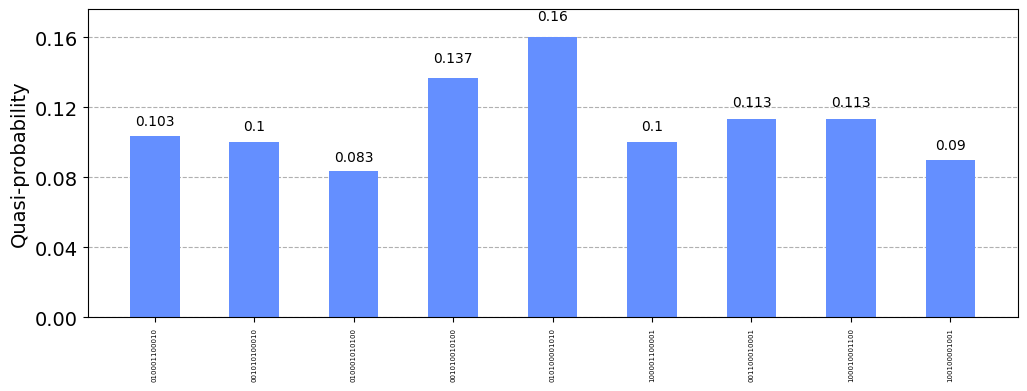

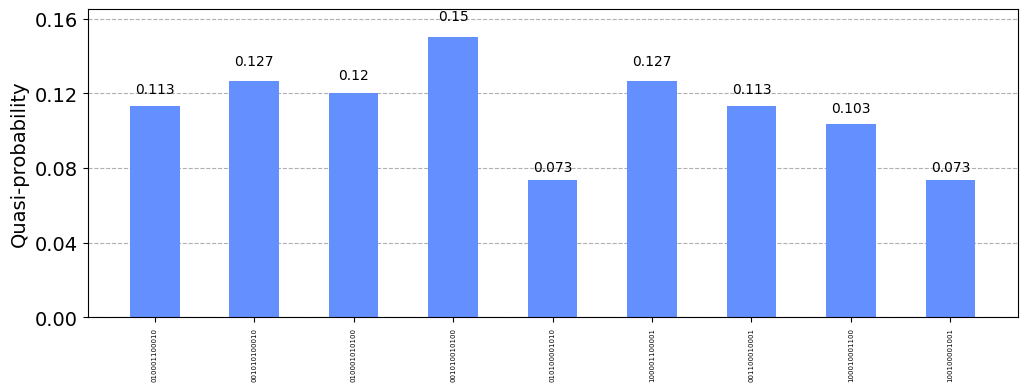

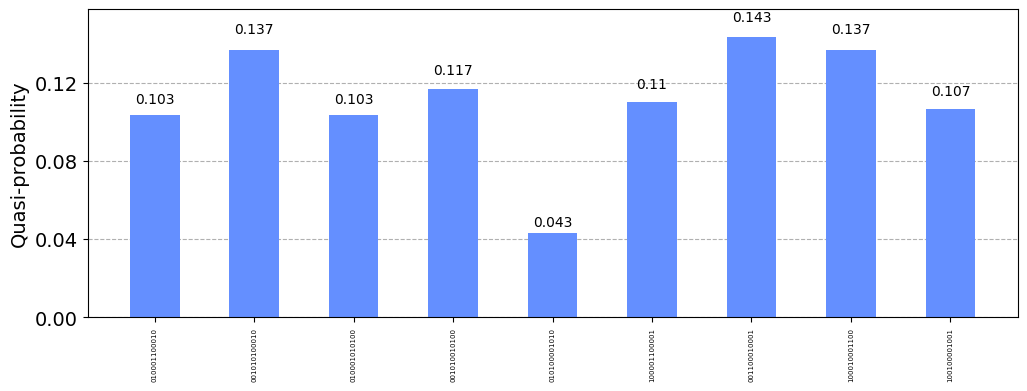

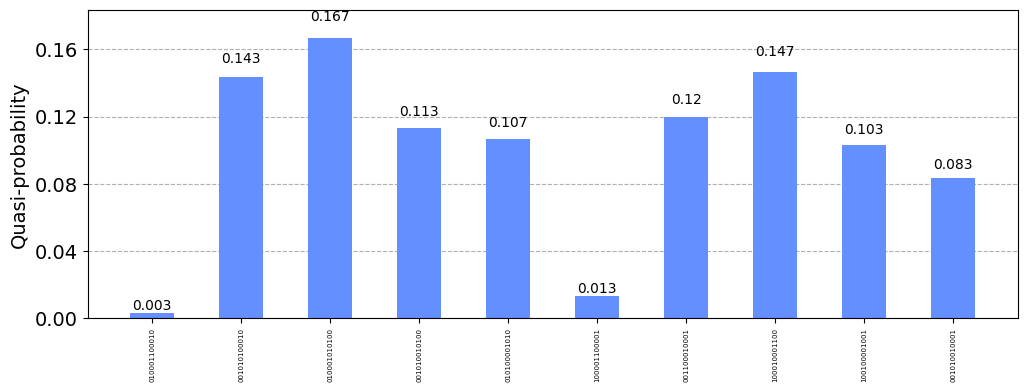

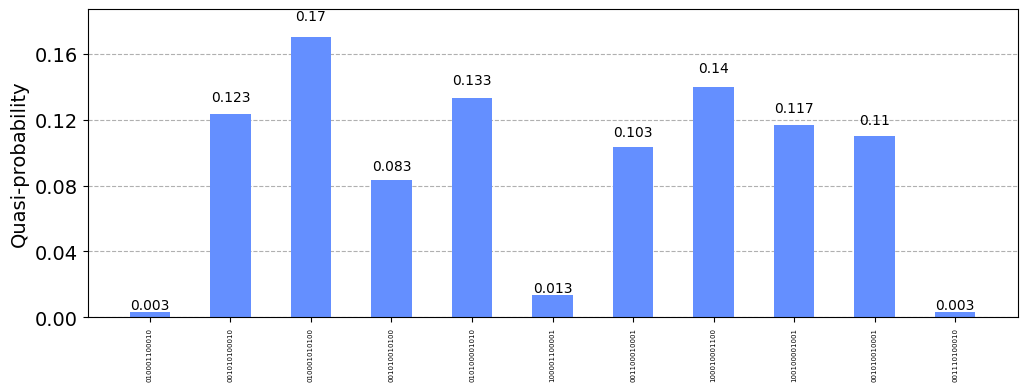

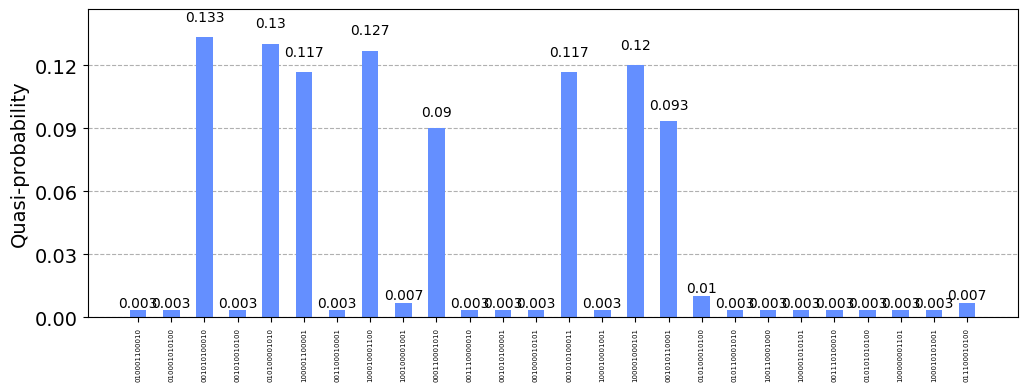

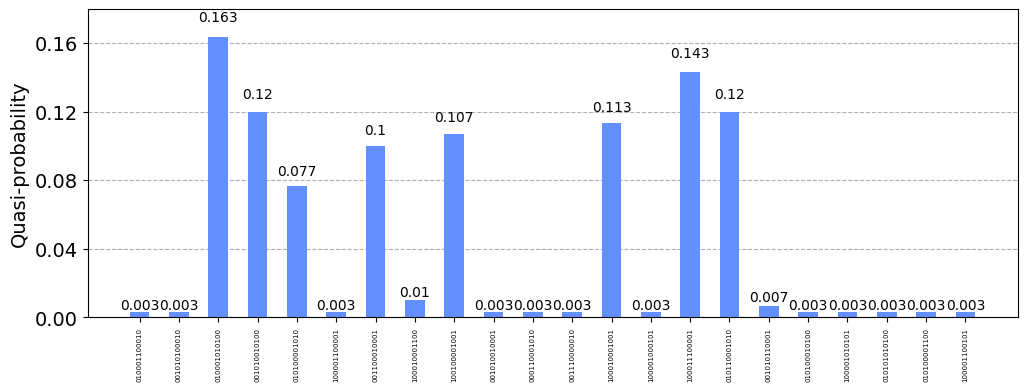

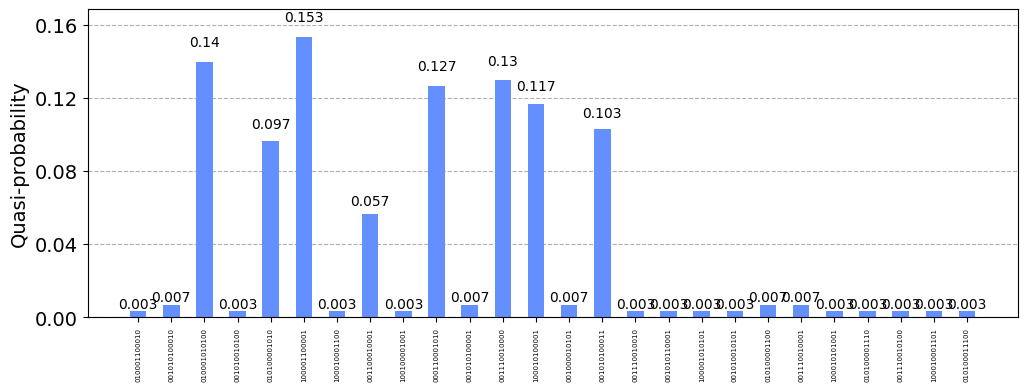

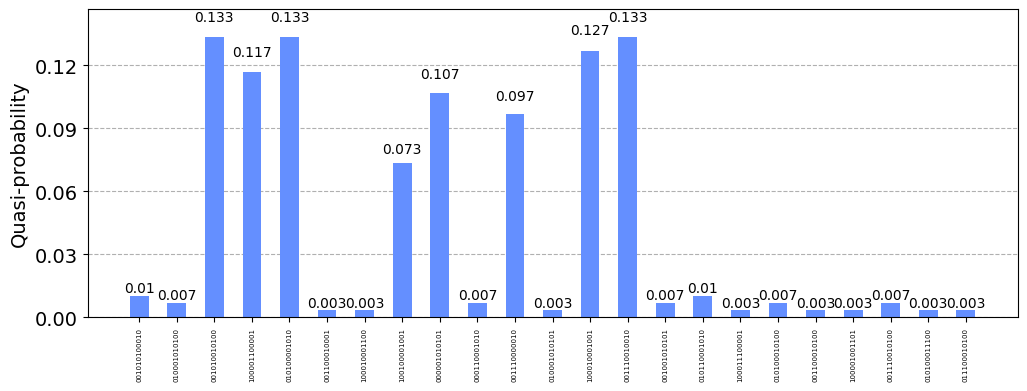

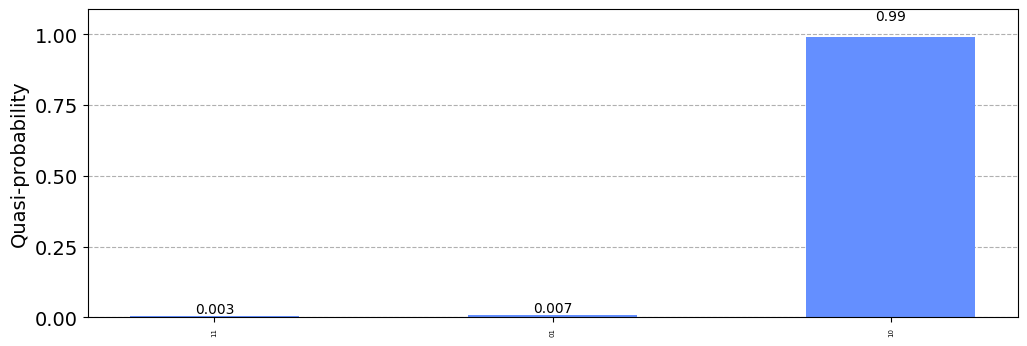

In [167]:
test_data['QA_QPU_Access_Time_TSP'+clusters_str] = 0
test_data['Max_Num_Qubits_TSP'+clusters_str] = []
if solver=='Advantage_system6.2':
  test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str] = []
  test_data['Shortest_Chain_Length_TSP'+clusters_str] = []
  test_data['Longest_Chain_Length_TSP'+clusters_str] = []

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)
clusters = clusters_dict['annealing'+clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo(cluster, p, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [168]:
results = list(tsp_solutions.values())
print(results)
test_data['QA_Execution_Time_TSP'+clusters_str] = end_time - start_time
test_data['QA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['Max_Num_Qubits_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Max_Num_Qubits_TSP'+clusters_str]])
if solver=='Advantage_system6.2':
  test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str]])
  test_data['Shortest_Chain_Length_TSP'+clusters_str] = np.min([num_qubits for num_qubits in test_data['Shortest_Chain_Length_TSP'+clusters_str]])
  test_data['Longest_Chain_Length_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Longest_Chain_Length_TSP'+clusters_str]])

[([(0, 4), (1, 3), (3, 0), (4, 1)], 32), ([(0, 2), (2, 0)], 20)]


### VQE

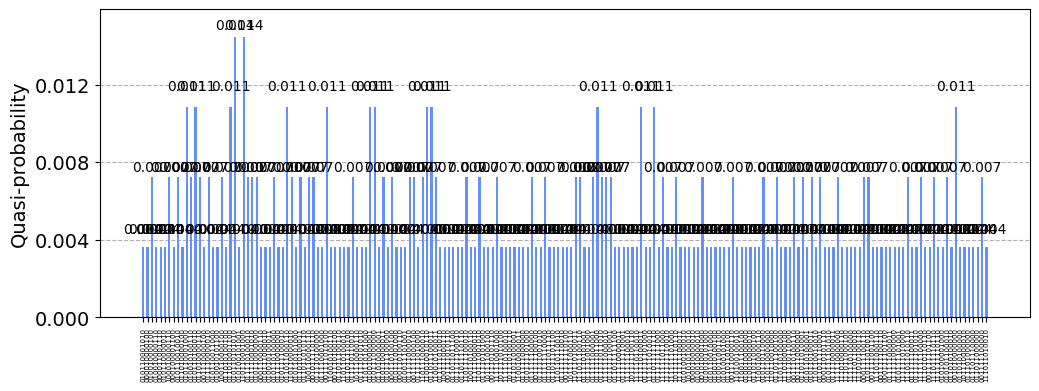

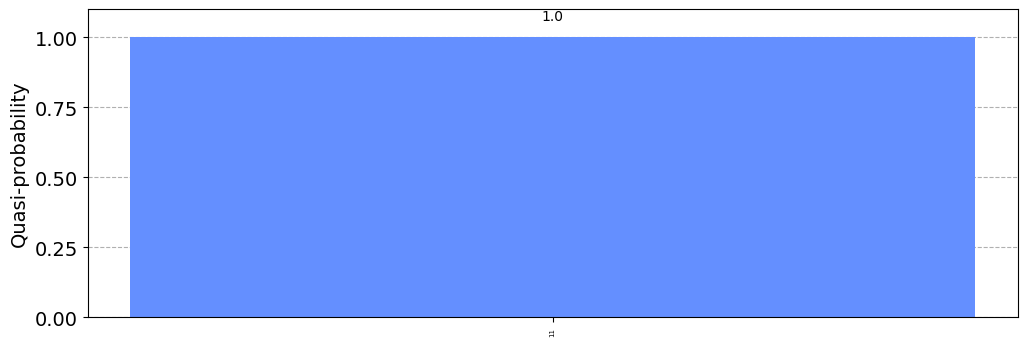

In [169]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

clusters = clusters_dict['vqe'+clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
# cl_opt_index = 11
# num_iter = 125
# max_depth = 1
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='VQE', cl_opt_index=cl_opt_index,
                                                   circuit_depth=max_depth, num_iter=num_iter, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [170]:
results = list(tsp_solutions.values())
print(results)
test_data['VQE_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['VQE_Classical_Optimizer_TSP'+clusters_str] = cl_opt_names[cl_opt_index]
test_data['VQE_Classical_Optimizer_TSP_Num_Iter'+clusters_str] = num_iter
test_data['VQE_Circuit_Depth_TSP'+clusters_str] = max_depth
test_data['VQE_Execution_Time_TSP'+clusters_str] = end_time-start_time

[([(0, 3), (1, 0), (1, 3), (3, 4), (4, 1)], 45.0), ([(0, 2), (2, 0)], 20.0)]


### QAOA

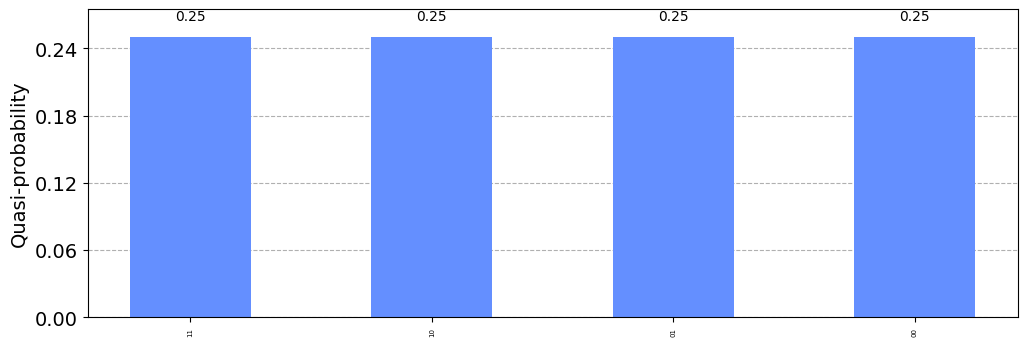

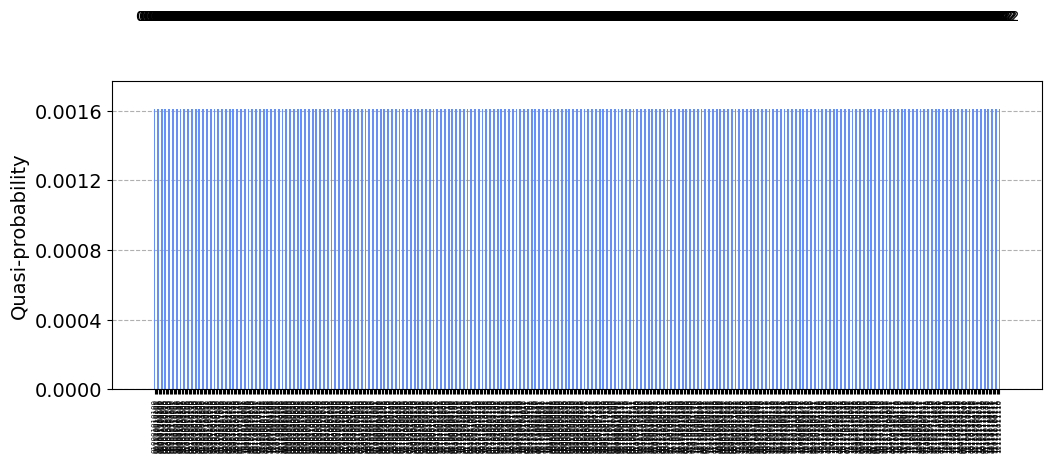

In [171]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

clusters = clusters_dict['qaoa'+clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
# cl_opt_index = 11
# num_iter = 125
# max_depth = 1
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='QAOA', cl_opt_index=cl_opt_index,
                                                   circuit_depth=max_depth, num_iter=num_iter, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [172]:
results = list(tsp_solutions.values())
print(results)
test_data['QAOA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['QAOA_Classical_Optimizer_TSP'+clusters_str] = cl_opt_names[cl_opt_index]
test_data['QAOA_Classical_Optimizer_TSP_Num_Iter'+clusters_str] = num_iter
test_data['QAOA_Circuit_Depth_TSP'+clusters_str] = max_depth
test_data['QAOA_Execution_Time_TSP'+clusters_str] = end_time-start_time

[([(0, 2), (2, 0)], 20.0), ([(0, 3), (1, 4), (3, 1), (4, 0)], 32.0)]


## Graver Augmented Multiseed Algorithm

In [173]:
test_data_gama = {}
test_data_gama['QuGAMA_Num_Graver_Basis_TSP'] = []
test_data_gama['QuGAMA_Num_Feasible_Sols_TSP'] = []

clusters = clusters_dict['gama'+clusters_str]

# solve TSP individually on each cluster
tsp_solutions = {}
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gama(cluster, clusters_str)
end_time = now()

In [174]:
results = list(tsp_solutions.values())
print(results)
test_data['QuGAMA_Execution_Time_TSP'+clusters_str] = end_time - start_time
test_data['QuGAMA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['QuGAMA_Min_Num_Graver_Basis_TSP'+clusters_str] = np.min([el for el in test_data_gama['QuGAMA_Num_Graver_Basis_TSP']])
test_data['QuGAMA_Max_Num_Graver_Basis_TSP'+clusters_str] = np.max([el for el in test_data_gama['QuGAMA_Num_Graver_Basis_TSP']])
test_data['QuGAMA_Min_Num_Feasible_Sols_TSP'+clusters_str] = np.min([el for el in test_data_gama['QuGAMA_Num_Feasible_Sols_TSP']])
test_data['QuGAMA_Max_Num_Feasible_Sols_TSP'+clusters_str] = np.max([el for el in test_data_gama['QuGAMA_Num_Feasible_Sols_TSP']])

[([(0, 4), (1, 3), (3, 0), (4, 1)], 32.0), ([(0, 2), (2, 0)], 20.0)]


# 2-Phase Heuristic: Routing (Travelling Salesman Problem - Louvain Clusters)

## Formulation with DFJ Method for sequential subtour elimination

\begin{alignat*}{2}
\text{Minimize} \quad & \sum_{i, j} c_{ij}x_{ij} \\
\text{subject to} \quad & \sum_{j \in N^{+}(i)} x_{ij} = 1 \quad \forall i \in Cluster\\
& \sum_{i \in N^{-}(j)} x_{ij} = 1 \quad \forall j \in Cluster\\
& \sum_{i \in S} \sum_{j \notin S} x_{ij} \geq 1 \quad \forall S \;\;\text{subtour}\\
& x_{ij} \in \{0, 1\} \quad \forall i,j \in Cluster
\end{alignat*}

In [175]:
# available clusters
clusters_dict = {
    'gurobi_MKP' : gurobi_clusters,
    'gurobi_MM' : gurobi_clusters_MM,

    'annealing_MKP' : annealing_clusters,
    'annealing_MM' : annealing_clusters_MM,

    'vqe_MKP' : vqe_clusters,
    'vqe_MM' : vqe_clusters_MM,

    'qaoa_MKP' : qaoa_clusters,
    'qaoa_MM' : qaoa_clusters_MM,

    'gama_MKP' : gama_clusters,
    'gama_MM' : gama_clusters_MM,

    '_louvain' : louvain_clusters
}

clusters_str = '_louvain'

## Gurobi

In [176]:
clusters = clusters_dict[clusters_str]
test_data['Gurobi_Execution_Time_TSP'+clusters_str] = 0

# solve TSP individually on each cluster
tsp_solutions = {}
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gurobi(cluster, clusters_str=clusters_str)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 6 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xc686140d
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 32 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e+01, best bound 3.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|

In [177]:
results = list(tsp_solutions.values())
print(results)
test_data['Gurobi_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])

[([(0, 1), (1, 4), (4, 0)], 32.0), ([(0, 2), (2, 3), (3, 0)], 28.0)]


## QUBO

### Quantum Annealing

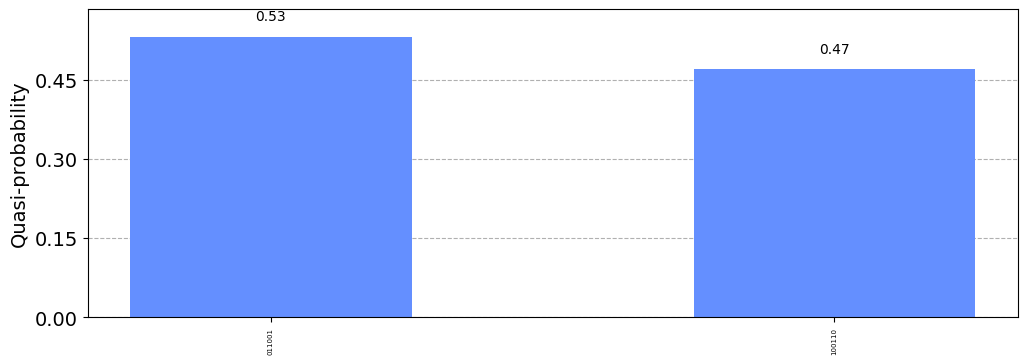

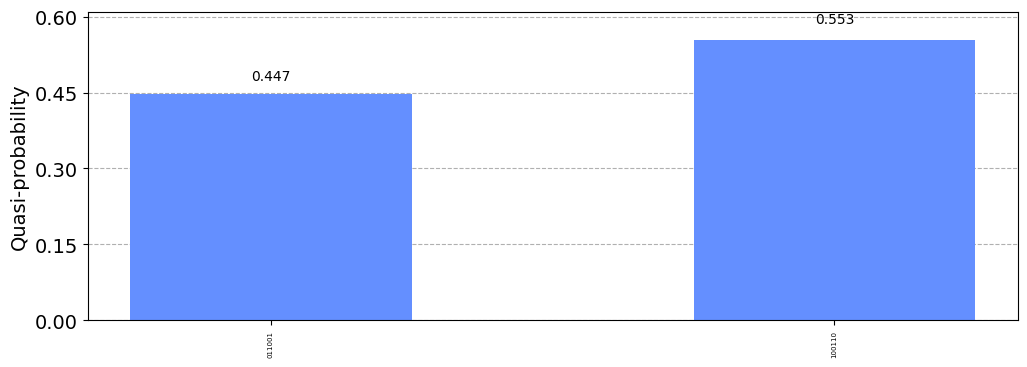

In [178]:
test_data['QA_QPU_Access_Time_TSP'+clusters_str] = 0
test_data['Max_Num_Qubits_TSP'+clusters_str] = []
if solver=='Advantage_system6.2':
  test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str] = []
  test_data['Shortest_Chain_Length_TSP'+clusters_str] = []
  test_data['Longest_Chain_Length_TSP'+clusters_str] = []

# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)
clusters = clusters_dict[clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo(cluster, p, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [179]:
results = list(tsp_solutions.values())
print(results)
test_data['QA_Execution_Time_TSP'+clusters_str] = end_time - start_time
test_data['QA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['Max_Num_Qubits_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Max_Num_Qubits_TSP'+clusters_str]])
if solver=='Advantage_system6.2':
  test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Max_Num_Qubits_Embedding_TSP'+clusters_str]])
  test_data['Shortest_Chain_Length_TSP'+clusters_str] = np.min([num_qubits for num_qubits in test_data['Shortest_Chain_Length_TSP'+clusters_str]])
  test_data['Longest_Chain_Length_TSP'+clusters_str] = np.max([num_qubits for num_qubits in test_data['Longest_Chain_Length_TSP'+clusters_str]])

[([(0, 4), (1, 0), (4, 1)], 32), ([(0, 3), (2, 0), (3, 2)], 28)]


### VQE

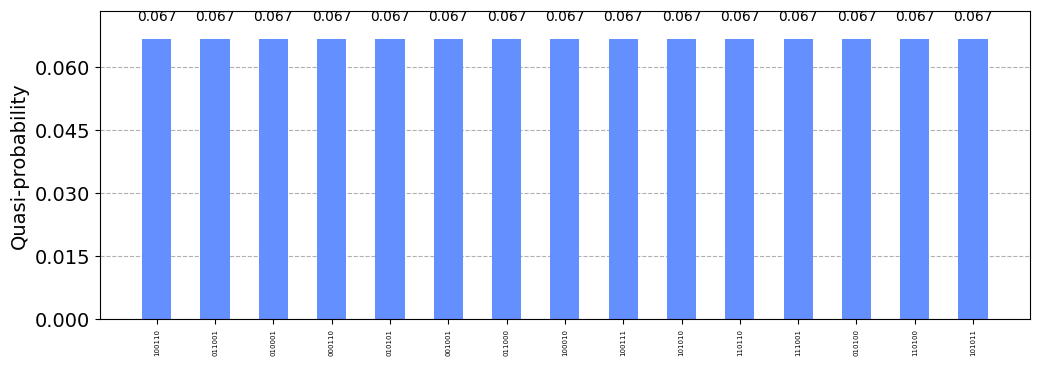

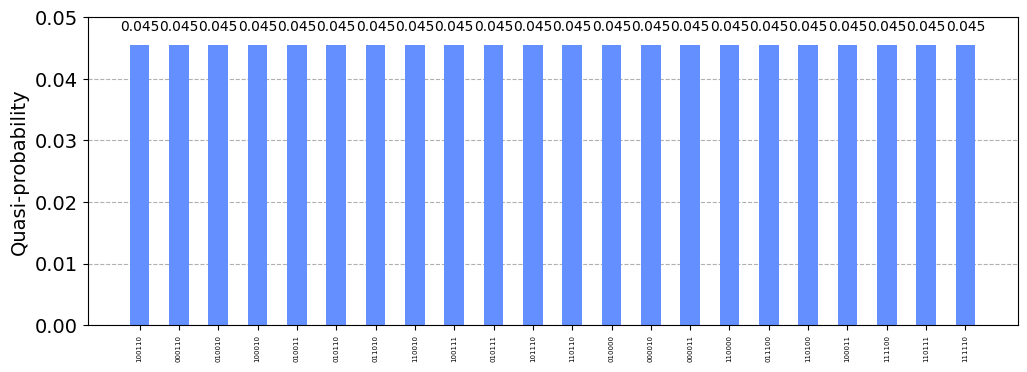

In [180]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

clusters = clusters_dict[clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
# cl_opt_index = 11
# num_iter = 125
# max_depth = 1
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='VQE', cl_opt_index=cl_opt_index,
                                                   circuit_depth=max_depth, num_iter=num_iter, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [181]:
results = list(tsp_solutions.values())
print(results)
test_data['VQE_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['VQE_Classical_Optimizer_TSP'+clusters_str] = cl_opt_names[cl_opt_index]
test_data['VQE_Classical_Optimizer_TSP_Num_Iter'+clusters_str] = num_iter
test_data['VQE_Circuit_Depth_TSP'+clusters_str] = max_depth
test_data['VQE_Execution_Time_TSP'+clusters_str] = end_time-start_time

[([(0, 1), (1, 4), (4, 0)], 32.0), ([(0, 2), (2, 3), (3, 0)], 28.0)]


### QAOA

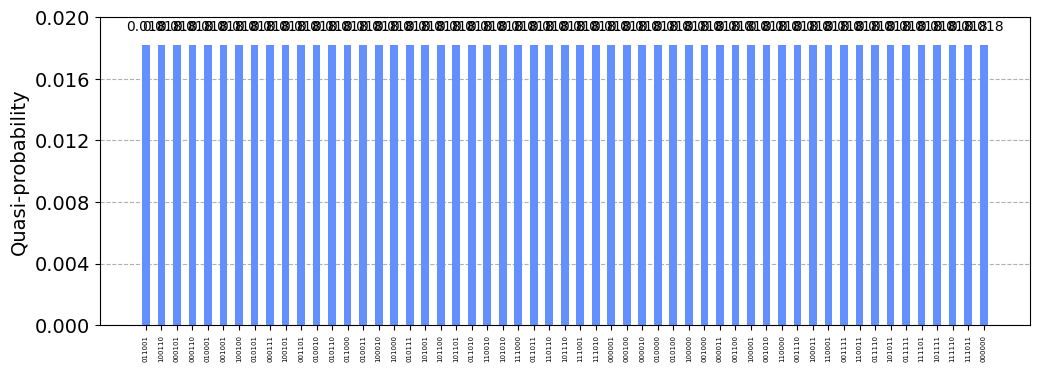

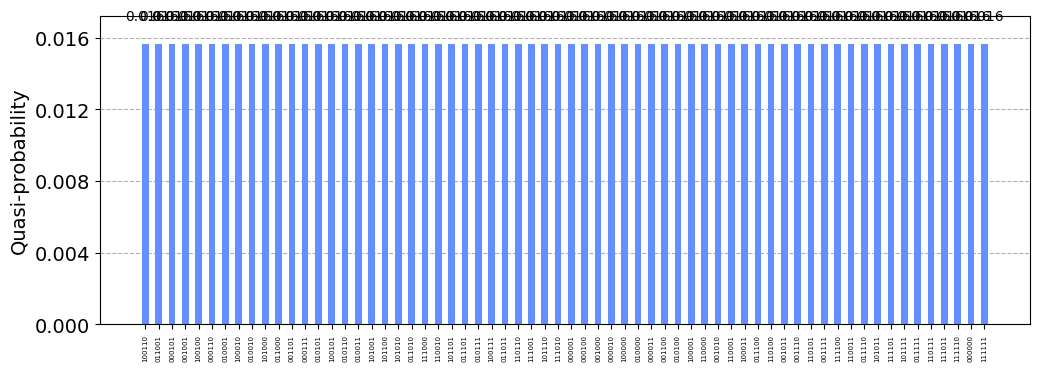

In [182]:
# penalty factors for QUBO
p = np.sum(E)+1
# p = n*np.max(E)

clusters = clusters_dict[clusters_str]

# solve TSP individually on each cluster using Quantum Annealing
tsp_solutions = {}
# cl_opt_index = 11
# num_iter = 125
# max_depth = 1
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_qubo_VQA(cluster, p, VQA='QAOA', cl_opt_index=cl_opt_index,
                                                   circuit_depth=max_depth, num_iter=num_iter, show_hist=True, clusters_str=clusters_str)
end_time = now()

In [183]:
results = list(tsp_solutions.values())
print(results)
test_data['QAOA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['QAOA_Classical_Optimizer_TSP'+clusters_str] = cl_opt_names[cl_opt_index]
test_data['QAOA_Classical_Optimizer_TSP_Num_Iter'+clusters_str] = num_iter
test_data['QAOA_Circuit_Depth_TSP'+clusters_str] = max_depth
test_data['QAOA_Execution_Time_TSP'+clusters_str] = end_time-start_time

[([(0, 4), (1, 0), (4, 1)], 32.0), ([(0, 2), (2, 3), (3, 0)], 28.0)]


## Graver Augmented Multiseed Algorithm

In [184]:
test_data_gama = {}
test_data_gama['QuGAMA_Num_Graver_Basis_TSP'] = []
test_data_gama['QuGAMA_Num_Feasible_Sols_TSP'] = []

clusters = clusters_dict[clusters_str]

# solve TSP individually on each cluster
tsp_solutions = {}
start_time = now()
for cluster in clusters:
  tsp_solutions[tuple(cluster)] = TSP_DFJ_gama(cluster, clusters_str)
end_time = now()

In [185]:
results = list(tsp_solutions.values())
print(results)
test_data['QuGAMA_Execution_Time_TSP'+clusters_str] = end_time - start_time
test_data['QuGAMA_Optimal_Objective_TSP'+clusters_str] = np.sum([el[1] for el in results])
test_data['QuGAMA_Min_Num_Graver_Basis_TSP'+clusters_str] = np.min([el for el in test_data_gama['QuGAMA_Num_Graver_Basis_TSP']])
test_data['QuGAMA_Max_Num_Graver_Basis_TSP'+clusters_str] = np.max([el for el in test_data_gama['QuGAMA_Num_Graver_Basis_TSP']])
test_data['QuGAMA_Min_Num_Feasible_Sols_TSP'+clusters_str] = np.min([el for el in test_data_gama['QuGAMA_Num_Feasible_Sols_TSP']])
test_data['QuGAMA_Max_Num_Feasible_Sols_TSP'+clusters_str] = np.max([el for el in test_data_gama['QuGAMA_Num_Feasible_Sols_TSP']])

[([(0, 4), (1, 0), (4, 1)], 32.0), ([(0, 3), (2, 0), (3, 2)], 28.0)]


# Save everything on drive

In [186]:
# Append the test data as a new row to the DataFrame
df = df.append(test_data, ignore_index=True)

# Save the updated DataFrame to the CSV file on Google Drive
df.to_csv(file_path, index=False)

<ipython-input-186-991e0934d128>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(test_data, ignore_index=True)
